# 1. Inport libraries

* Data processing: numpy, pandas

* Visualization: matplotlib, seaborn

* Hyperparameter tunning: hyperopt

* Maching learning packages:
  * LightGBM: lightgbm
  * scikit-learn

* Model interpretation:
  * SHapley Additive exPlanations: shap
  * Decision tree visualization: dtreeviz

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
#from sklearn.metrics import mean_squared_error, f1_score
#from sklearn.model_selection import StratifiedKFold, KFold

import copy
import gc
#import json
#from pathlib import Path
#import sys
#import os
#import pickle
#import joblib

#import pyarrow.parquet as pq
#import pyarrow as pa

from datetime import datetime, date, time

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings("ignore")

# 2. Load data

For Task 1, load the "nyra_start_table.csv" and "nyra_race_table.csv" CSV files for prediction.

* nyra_start_table.csv - horse/jockey race data
* nyra_race_table.csv - racetrack race data

We can notice that there are three columns exist in all the above four tables, which can be viewed as keys. They are:

* track_id
* race_date
* race_number

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
race_df = pd.read_csv('/content/drive/MyDrive/data/nyra_race_table.csv')
start_df = pd.read_csv('/content/drive/MyDrive/data/nyra_start_table.csv', header=None)
# tracking_df = pd.read_csv('/content/drive/MyDrive/Postgraduate/big-data-derby-2022/nyra_tracking_table.csv')

start_df.columns = ['track_id', 'race_date', 'race_number', 'program_number', 
             'weight_carried', 'jockey', 'odds', 'position_at_finish']
task1_df = start_df.merge(race_df, on=['track_id','race_date', 'race_number'], how='inner')

# 3. EDA

EDA to get knowledge about how each feature in the files distributed, also might found outliers within the data of each feature.

In [4]:
race_type_dict = {'STK':'Stakes', 'WCL':'Waiver Claiming', 'WMC':'Waiver Maiden Claiming', 'SST':'Starter Stakes', 
          'SHP':'Starter Handicap', 'CLM':'Claiming', 'STR':'Starter Allowance', 'AOC':'Allowance Optionl Claimer', 
          'SOC':'Starter Optional Claimer', 'MCL':'Maiden Claiming', 'ALW':'Allowance', 'MSW':'Maiden Special Weight'}
track_id_dict = dict(AQU='Aqueduct', BEL='Belmont', SAR='Saratoga')
course_type_dict = dict(M='Hurdle', D='Dirt', O='Outer turf', I='Inner turf', T='turf')
track_condition_dict = dict(YL='Yielding', FM='Firm', SY='Sloppy', GD='Good', FT='Fast', MY='Muddy', SF='Soft')

EDA_race_df = race_df.copy()
EDA_race_df['race_type'] = EDA_race_df['race_type'].map(race_type_dict)
EDA_race_df['track_id'] = EDA_race_df['track_id'].map(track_id_dict)
EDA_race_df['course_type'] = EDA_race_df['course_type'].map(course_type_dict)
EDA_race_df['track_condition'] = EDA_race_df['track_condition'].apply(lambda x:x.replace(" ", ''))
EDA_race_df['track_condition'] = EDA_race_df['track_condition'].map(track_condition_dict)
EDA_start_df = start_df.copy()
EDA_start_df['track_id'] = EDA_start_df['track_id'].map(track_id_dict)
print(EDA_start_df.shape, EDA_start_df.shape)

EDA_df = EDA_start_df.merge(EDA_race_df, on=['track_id','race_date','race_number'], how='inner')
print(EDA_df.shape)

(14915, 8) (14915, 8)
(14915, 15)


In [5]:
EDA_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14915 entries, 0 to 14914
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   track_id            14915 non-null  object
 1   race_date           14915 non-null  object
 2   race_number         14915 non-null  int64 
 3   program_number      14915 non-null  object
 4   weight_carried      14915 non-null  int64 
 5   jockey              14915 non-null  object
 6   odds                14915 non-null  int64 
 7   position_at_finish  14915 non-null  int64 
 8   distance_id         14915 non-null  int64 
 9   course_type         14915 non-null  object
 10  track_condition     14915 non-null  object
 11  run_up_distance     14915 non-null  int64 
 12  race_type           14915 non-null  object
 13  purse               14915 non-null  int64 
 14  post_time           14915 non-null  int64 
dtypes: int64(8), object(7)
memory usage: 1.8+ MB


In [6]:
EDA_df.nunique()

track_id                3
race_date             217
race_number            13
program_number         20
weight_carried         35
jockey                178
odds                  656
position_at_finish     14
distance_id            20
course_type             5
track_condition         7
run_up_distance       127
race_type              12
purse                  70
post_time             360
dtype: int64

In [7]:
EDA_df.describe(include=['object'])

,track_id,race_date,program_number,jockey,course_type,track_condition,race_type
count,14915,14915,14915,14915,14915,14915,14915
unique,3,217,20,178,5,7,12
top,Aqueduct,2019-08-24,4,Manuel Franco,Dirt,Fast,Claiming
freq,6191,117,1748,1274,9467,6921,3329


In [8]:
EDA_df.describe(exclude=['object'])

,race_number,weight_carried,odds,position_at_finish,distance_id,run_up_distance,purse,post_time
count,14915.000000,14915.000000,14915.000000,14915.000000,14915.000000,14915.000000,1.491500e+04,14915.000000
mean,5.494200,120.454040,1483.496480,4.486088,725.454241,66.806436,8.367621e+04,412.094200
std,2.826058,3.522007,1956.137156,2.569144,150.055597,36.902299,1.143569e+05,272.818096
min,1.000000,110.000000,0.000000,1.000000,450.000000,0.000000,1.600000e+04,100.000000
25%,3.000000,118.000000,335.000000,2.000000,600.000000,45.000000,4.100000e+04,230.000000
50%,6.000000,120.000000,730.000000,4.000000,700.000000,54.000000,6.200000e+04,347.000000
75%,8.000000,122.000000,1740.000000,6.000000,800.000000,78.000000,8.000000e+04,512.000000
max,13.000000,160.000000,19100.000000,14.000000,2000.000000,280.000000,1.500000e+06,1259.000000


In [9]:
def bar(data, caption, figsize=(12, 6)):
  if data.index.dtype in ['int64', 'int32', 'float64', 'float32']:
    data.index = data.index.astype(str)
  plt.figure(figsize=figsize)
  plt.style.use('seaborn-whitegrid')
  plt.barh(data.index.values, data.values, color="lightseagreen", alpha=0.7)
  for i, v in enumerate(data.values):
    plt.text(v + 3.9, i + .025, str(v), fontsize=10, color="teal", fontweight='bold')#deepskyblue#dodgerblue
  plt.title(caption, fontsize=12, loc='left')
  plt.xticks([])
  plt.grid(visible=True, which='major', axis='both', color='lightgray', linestyle='-', linewidth=0.2)
  plt.rc('ytick', labelsize=10)   
  plt.show()

def hist(data, name, bins=50):
    plt.figure(figsize=(6,4))
    plt.style.use('seaborn-whitegrid')
    plt.hist(data, bins=bins, facecolor='#4ac2fb')
    plt.title(name, fontsize=12)
    plt.axvline(np.array(data.mean()), color='tomato', ls='--', lw=2)
    plt.grid(visible=True, which='major', axis='both', color='lightgray', linestyle='--', linewidth=0.5)
    plt.show()  

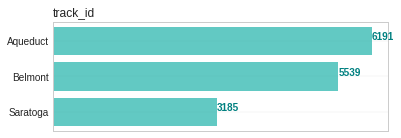

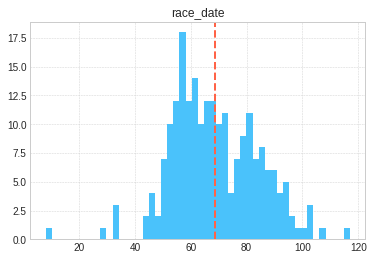

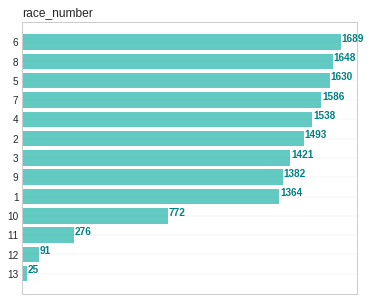

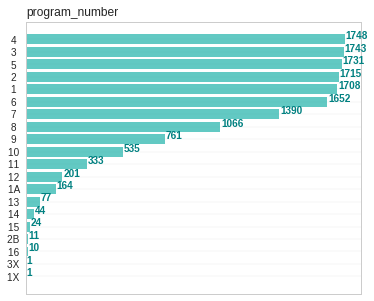

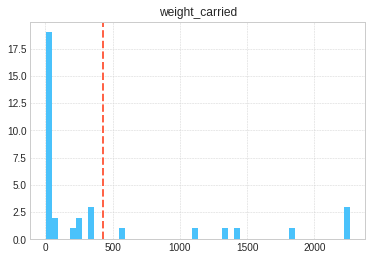

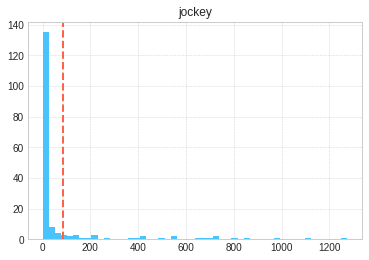

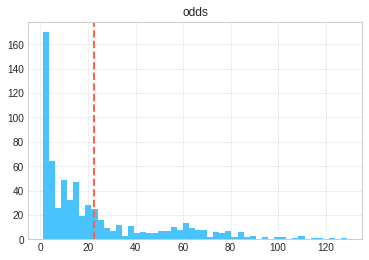

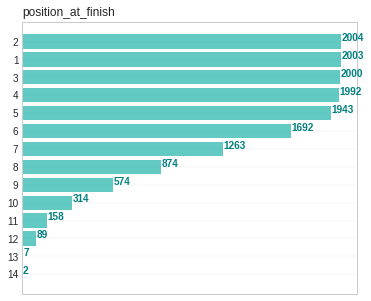

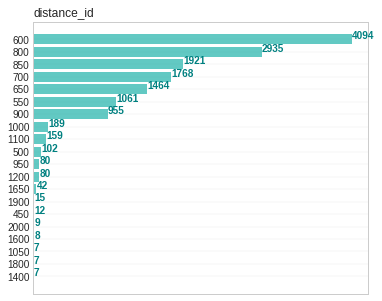

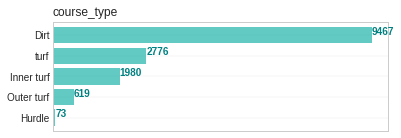

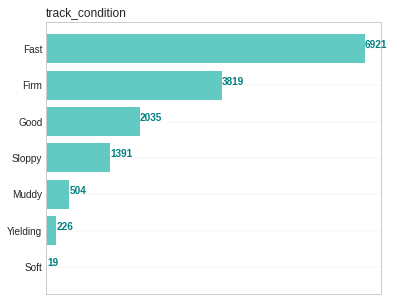

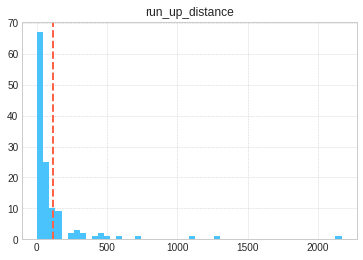

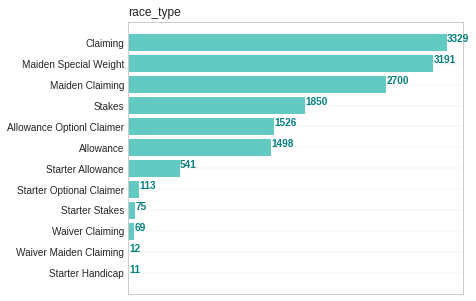

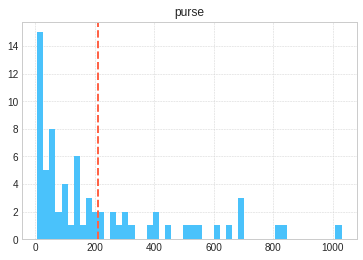

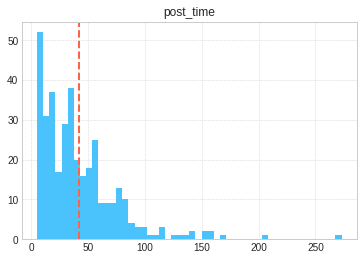

In [10]:
for col in EDA_df.columns:
  data = EDA_df[col].value_counts().sort_values()
  if data.shape[0] <= 5:
    bar(data, col, figsize=(6, 2))
  elif data.shape[0] <= 20:
    bar(data, col, figsize=(6, 5))
  else:
    hist(data, col)
plt.show()

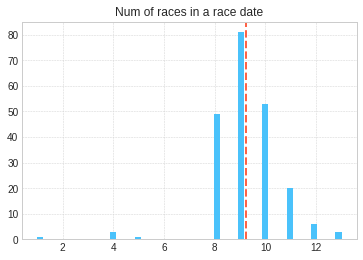

In [11]:
data = EDA_race_df[['race_date', 'race_number']].groupby('race_date').count()['race_number']
hist(data, 'Num of races in a race date')

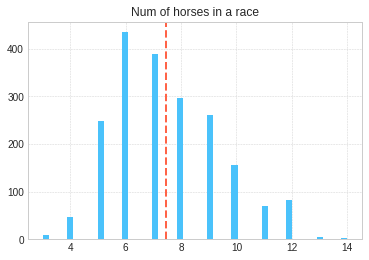

In [12]:
data = EDA_df[['race_date', 'race_number', 'program_number']].groupby(['race_date', 'race_number',]).count()['program_number']
hist(data, 'Num of horses in a race')

# 4. Data Preprocessing

In [13]:
# Check whether there is any null value
task1_df.isna().sum()

track_id              0
race_date             0
race_number           0
program_number        0
weight_carried        0
jockey                0
odds                  0
position_at_finish    0
distance_id           0
course_type           0
track_condition       0
run_up_distance       0
race_type             0
purse                 0
post_time             0
dtype: int64

In [14]:
task1_df.sort_values(by=['track_id', 'race_date', 'race_number', 'program_number'], ascending=[True]*4, inplace=True)
task1_df['id'] = range(1, start_df.shape[0] +1)

1. remove some outliers based on EDA results (task1_df_drop):
  * remove race_date which have less than 8 races
  * remove races which have less than 5 horses or more than 12 horses
  * remove races whose 'course_type' are 'Hurdle' ('M')
  * remove races whose 'track_condition' are 'Soft' ('SF')
  * remove races whose 'distance_id' > 1200
  * remove races whose 'race_type' are in 'Waiver Maiden Claiming', 'Starter Handicap' and 'Waiver Claiming' ('WMC','SHP','WCL')

2. keep outliers (task1_df)

In [15]:
task1_df_drop = task1_df.copy()

# remove race_date which have less than 8 races
race_num = race_df[['race_date', 'race_number']].groupby('race_date').count()
remove_race_dates = race_num[race_num['race_number']<8].index.tolist()
print('The original shape is:', task1_df_drop.shape)
task1_df_drop = task1_df_drop.drop(index=task1_df_drop[task1_df_drop['race_date'].isin(remove_race_dates)].index)
print('Now the shape is:', task1_df_drop.shape)

# remove races which have less than 5 horses or more than 12 horses
horse_num = task1_df_drop[['race_date', 'race_number', 'program_number']].groupby(['race_date', 'race_number',]).count()
remove_horse_num = horse_num[(horse_num['program_number']<5)|(horse_num['program_number']>12)].reset_index().iloc[:, :2]
remove_horse_num = task1_df_drop.merge(remove_horse_num, on=['race_date', 'race_number'], how='inner')
task1_df_drop = task1_df_drop.drop(index = task1_df_drop[task1_df_drop['id'].isin(remove_horse_num['id'].values)].index)
print('Now the shape is:', task1_df_drop.shape)

# remove races whose 'course_type' are 'Hurdle' ('M')
task1_df_drop = task1_df_drop.drop(index=task1_df_drop[task1_df_drop['course_type'].isin(['M',])].index)
print('Now the shape is:', task1_df_drop.shape)

# remove races whose 'track_condition' are 'Soft' ('SF')
task1_df_drop = task1_df_drop.drop(index=task1_df_drop[task1_df_drop['track_condition'].isin(['SF',])].index)
print('Now the shape is:', task1_df_drop.shape)

# remove races whose 'distance_id' > 1200
task1_df_drop = task1_df_drop.drop(index=task1_df_drop[task1_df_drop['distance_id']>1200].index)
print('Now the shape is:', task1_df_drop.shape)

# remove races whose 'race_type' are in 'Waiver Maiden Claiming', 'Starter Handicap' and 'Waiver Claiming' ('WMC','SHP','WCL')
race_types_to_remove = []
for k, v in race_type_dict.items():
  if v in ['Waiver Maiden Claiming', 'Starter Handicap', 'Waiver Claiming']:
    race_types_to_remove.append(k)
task1_df_drop = task1_df_drop.drop(index=task1_df_drop[task1_df_drop['race_type'].isin(['WMC','SHP','WCL'])].index)
print('Now the shape is:', task1_df_drop.shape)

The original shape is: (14915, 16)
Now the shape is: (14780, 16)
Now the shape is: (14475, 16)
Now the shape is: (14414, 16)
Now the shape is: (14414, 16)
Now the shape is: (14399, 16)
Now the shape is: (14307, 16)


# 5. Target Engineering

Use position_at_finish (An integer of the horse's finishing position) to engineer a binary target to indicate if a jockey won a race or not.

In [16]:
task1_df_drop = task1_df_drop.sort_values(by=['track_id', 'race_date', 'race_number', 'program_number'], ascending=[True]*4)

1. Method 1 (Win): If position_at_finish is 1, it means that this jockey won the first place in a race, the target is 1; otherwise the target is 0. ('target_win)

2. Method 2 (Place): If position_at_finish is 1, 2 or 3 , it means that the jockey won one of the first three places in a race, the target is 1; otherwise the target is 0. ('target_place')

In [17]:
task1_df_drop = task1_df_drop.copy()

task1_df_drop['target_win'] = (task1_df_drop['position_at_finish']==1).astype(int)
print('If use method one (Win): \n')
print(task1_df_drop['target_win'].value_counts())
print(task1_df_drop['target_win'].value_counts()/task1_df_drop.shape[0])

task1_df_drop['target_plc'] = (task1_df_drop['position_at_finish']<4).astype(int)
print('If use method two (Place): \n')
print(task1_df_drop['target_plc'].value_counts())
print(task1_df_drop['target_plc'].value_counts()/task1_df_drop.shape[0])

If use method one (Win): 

0    12406
1     1901
Name: target_win, dtype: int64
0    0.867128
1    0.132872
Name: target_win, dtype: float64
If use method two (Place): 

0    8607
1    5700
Name: target_plc, dtype: int64
0    0.601594
1    0.398406
Name: target_plc, dtype: float64


# 6. Feature Engineering
* create dummy features for categorical features
* create features from race_date and post_time
* create descriptive statistical features
* jockey: create id for jockey
* jockey's previous win rate and place rate

## Create dummy features for categorical features

In [18]:
def post_time_(x):
  # majority time 13:00 - 18:00 : 0
  # not majority time: 1
    
  x = str(x)
  x1_, x2_ = int(x[:-2]), int(x[-2:])
  if x1_ < 10:
    x1_ = x1_ + 12
  v = int(f'{x1_}{x2_}')

  if v < 1300:
    r = 1
  elif v > 1800:
    r = 1
  else:
    r = 0
  return r

In [19]:
# create dummy features for categorical features

task1_df_drop['race_date'] = pd.to_datetime(task1_df_drop['race_date'])
task1_df_drop['weekday'] = task1_df_drop['race_date'].dt.weekday
task1_df_drop['month'] = task1_df_drop['race_date'].dt.month
task1_df_drop['post_time2'] = task1_df_drop['post_time'].apply(post_time_)

for column in ['track_id', 'course_type', 'track_condition', 'race_type']:
  dummies_ = pd.get_dummies(task1_df_drop[column])
  dummy_feats_ =  [f'{column}={cc}' for cc in dummies_.columns]
  dummies_.columns = dummy_feats_
  task1_df_drop[dummy_feats_] = dummies_.values

jockeys = task1_df_drop['jockey'].unique().tolist()
jockey_ids = pd.DataFrame(index=jockeys, data={'jockey_id': range(1, len(jockeys)+1)}).to_dict()['jockey_id']
task1_df_drop['jockey_id'] = task1_df_drop['jockey'].map(jockey_ids)

print('Now the shape is:', task1_df_drop.shape)

Now the shape is: (14307, 45)


## create descriptive statistical features

* the descriptive statistical features of jockey's performances
  * win rate before current rate_date
  * place rate before current rate_date
  * race count before current rate_date
  * win rate/place rate of current course type/track

In [20]:
perf = task1_df_drop[['jockey', 'race_date', 'position_at_finish']].groupby(['jockey', 'race_date']).count()
perf.columns = ['perf_cnt']
wins = task1_df_drop.loc[task1_df_drop['position_at_finish']<2,['jockey','race_date','position_at_finish']].groupby(['jockey','race_date']).count()
wins.columns = ['win_cnt']
places = task1_df_drop.loc[task1_df_drop['position_at_finish']<4,['jockey','race_date','position_at_finish']].groupby(['jockey','race_date']).count()
places.columns=['place_cnt']

perf = perf.reset_index()
wins = wins.reset_index()
places = places.reset_index()
perf.sort_values(by=['jockey', 'race_date'], ascending=[True]*2, inplace=True)
wins.sort_values(by=['jockey', 'race_date'], ascending=[True]*2, inplace=True)
places.sort_values(by=['jockey', 'race_date'], ascending=[True]*2, inplace=True)

perf = perf.merge(wins, on=['jockey', 'race_date'], how='left')
perf = perf.merge(places, on=['jockey', 'race_date'], how='left')
perf.fillna(0, inplace=True)

cumsum = perf.groupby('jockey').cumsum()
perf['perf_cumsum'] = cumsum['perf_cnt']
perf['win_rate'] = cumsum['win_cnt']/cumsum['perf_cnt']
perf['place_rate'] = cumsum['place_cnt']/cumsum['perf_cnt']

perf_ = perf.groupby('jockey').shift(1)
for column in perf_.columns:
    perf[f'pre_{column}'] = perf_[column]
perf.fillna(0, inplace=True)

task1_df_drop = task1_df_drop.merge(perf, on=['jockey', 'race_date'], how='left')
print('Now the shape is:', task1_df_drop.shape)

Now the shape is: (14307, 58)


In [21]:
task1_df_drop['win'] = (task1_df_drop['position_at_finish']<2).astype(int)
task1_df_drop['place'] = (task1_df_drop['position_at_finish']<4).astype(int)

In [22]:
jockeys = task1_df_drop['jockey'].value_counts()[task1_df_drop['jockey'].value_counts()>=10].index.values.tolist()
race_days = race_df['race_date'].unique().tolist()
race_days.sort()

data = pd.pivot_table(task1_df_drop, index=['race_date'], columns=['jockey'], values=['win', 'place'], 
               aggfunc={'win': [np.sum, np.size], 'place': np.sum} )
data.sort_index(ascending=True, inplace=True)

dfs_pre = []
for jk in jockeys:
  data_i = data[[('place','sum',jk), ('win','size',jk), ('win','sum',jk)]].fillna(0)
  data_i.columns = ['place', 'run', 'win']

  data_i['plc_sum'] = data_i['place'].rolling(31).apply(lambda x: x[:-1].sum())
  data_i['win_sum'] = data_i['win'].rolling(31).apply(lambda x: x[:-1].sum())
  data_i['run_sum'] = data_i['run'].rolling(31).apply(lambda x: x[:-1].sum())

  data_i['plc_rate'] = data_i['plc_sum'] / data_i['run_sum']
  data_i['win_rate'] = data_i['win_sum'] / data_i['run_sum']
  data_i['jockey'] = jk
    
  for col in ['plc_rate', 'win_rate']:
    for i in [3, 5, 10]:
      data_i[f'{col}_diff{i}'] = data_i[col].diff(i)
  dfs_pre.append(data_i.reset_index())
df_pre = pd.concat(dfs_pre)

new_cols = []
for col in df_pre.columns:
    if col in ['jockey', 'race_date']:
        new_cols.append(col)
    else:
        new_cols.append(f'pre31_{col}')
df_pre.columns = new_cols

task1_df_drop = task1_df_drop.merge(df_pre, on=['jockey', 'race_date'], how='left')

task1_df_drop = task1_df_drop.replace([-np.inf, np.inf], np.nan)
task1_df_drop = task1_df_drop.fillna(0)
print(task1_df_drop.isna().sum()[task1_df_drop.isna().sum()>0])

print('Now the shape is:', task1_df_drop.shape)

Series([], dtype: int64)
Now the shape is: (14307, 74)


In [23]:
task1_df_drop.head()

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,id,target_win,target_plc,weekday,month,post_time2,track_id=AQU,track_id=BEL,track_id=SAR,course_type=D,course_type=I,course_type=O,course_type=T,track_condition=FM,track_condition=FT,track_condition=GD,track_condition=MY,track_condition=SF,track_condition=SY,track_condition=YL,race_type=ALW,race_type=AOC,race_type=CLM,race_type=MCL,race_type=MSW,race_type=SOC,race_type=SST,race_type=STK,race_type=STR,jockey_id,perf_cnt,win_cnt,place_cnt,perf_cumsum,win_rate,place_rate,pre_race_date,pre_perf_cnt,pre_win_cnt,pre_place_cnt,pre_perf_cumsum,pre_win_rate,pre_place_rate,win,place,pre31_place,pre31_run,pre31_win,pre31_plc_sum,pre31_win_sum,pre31_run_sum,pre31_plc_rate,pre31_win_rate,pre31_plc_rate_diff3,pre31_plc_rate_diff5,pre31_plc_rate_diff10,pre31_win_rate_diff3,pre31_win_rate_diff5,pre31_win_rate_diff10
0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2,650,D,MY,36,AOC,80000,1220,1,0,1,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,6,1.0,3.0,6,0.166667,0.500000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,3.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3,650,D,MY,36,AOC,80000,1220,2,0,1,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,2,7,1.0,5.0,7,0.142857,0.714286,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,5.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AQU,2019-01-01,1,3,118,Jose Lezcano,180,4,650,D,MY,36,AOC,80000,1220,3,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,3,6,0.0,1.0,6,0.000000,0.166667,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AQU,2019-01-01,1,4,123,Jomar Garcia,1280,5,650,D,MY,36,AOC,80000,1220,4,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,4,2,0.0,0.0,2,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AQU,2019-01-01,1,5,118,Manuel Franco,1150,1,650,D,MY,36,AOC,80000,1220,5,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,5,7,1.0,3.0,7,0.142857,0.428571,0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,3.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
task1_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14307 entries, 0 to 14306
Data columns (total 74 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   track_id               14307 non-null  object        
 1   race_date              14307 non-null  datetime64[ns]
 2   race_number            14307 non-null  int64         
 3   program_number         14307 non-null  object        
 4   weight_carried         14307 non-null  int64         
 5   jockey                 14307 non-null  object        
 6   odds                   14307 non-null  int64         
 7   position_at_finish     14307 non-null  int64         
 8   distance_id            14307 non-null  int64         
 9   course_type            14307 non-null  object        
 10  track_condition        14307 non-null  object        
 11  run_up_distance        14307 non-null  int64         
 12  race_type              14307 non-null  object        
 13  p

# 7. Models for prediction

* create training and testing data
* Define multiple models for prediction
* Compare the performance of models

In [25]:
features = ['weight_carried', 'odds', 'distance_id', 'run_up_distance', 'purse', 'weekday', 'month', 
       'post_time2', 'track_id=AQU', 'track_id=BEL', 'track_id=SAR', 'course_type=D', 
       'course_type=I', 'course_type=O', 'course_type=T', 'track_condition=FM ', 'track_condition=FT ', 
       'track_condition=GD ', 'track_condition=MY ', 'track_condition=SF ', 'track_condition=SY ',
       'track_condition=YL ', 'race_type=ALW', 'race_type=AOC', 'race_type=CLM', 'race_type=MCL', 
       'race_type=MSW', 'race_type=SOC', 'race_type=SST', 'race_type=STK', 'race_type=STR', 'jockey_id', 
       'pre_perf_cnt', 'pre_win_cnt', 'pre_place_cnt', 'pre_perf_cumsum', 'pre_win_rate', 'pre_place_rate',
       'pre31_place', 'pre31_win', 'pre31_run', 'pre31_plc_sum', 'pre31_win_sum', 'pre31_run_sum', 
       'pre31_plc_rate', 'pre31_win_rate', 'pre31_plc_rate_diff3', 'pre31_plc_rate_diff5', 
       'pre31_plc_rate_diff10', 'pre31_win_rate_diff3', 'pre31_win_rate_diff5', 'pre31_win_rate_diff10']
len(features)

52

In [26]:
task1_df_drop[features].shape

(14307, 52)

In [27]:
task1_df_drop['target_win'].value_counts()

0    12406
1     1901
Name: target_win, dtype: int64

In [28]:
task1_df_drop['target_win'].value_counts()/len(task1_df_drop['target_win'])

0    0.867128
1    0.132872
Name: target_win, dtype: float64

In [29]:
task1_df_drop['target_plc'].value_counts()

0    8607
1    5700
Name: target_plc, dtype: int64

In [30]:
task1_df_drop['target_plc'].value_counts()/len(task1_df_drop['target_plc'])

0    0.601594
1    0.398406
Name: target_plc, dtype: float64

In [31]:
train_start, train_end = '2019-02-01', '2019-10-15'
test_start, test_end = '2019-10-15', '2020-01-01'

df_train = task1_df_drop[(task1_df_drop['race_date']>=train_start) & (task1_df_drop['race_date']<train_end)].copy()
df_test = task1_df_drop[(task1_df_drop['race_date']>=test_start) & (task1_df_drop['race_date']<test_end)].copy()

print(df_train.shape, df_test.shape)

(10407, 74) (3093, 74)


In [32]:
X_train, X_test = df_train[features], df_test[features]
y_train_win, y_test_win = df_train['target_win'], df_test['target_win']
y_train_plc, y_test_plc = df_train['target_plc'], df_test['target_plc']
print(X_train.shape, X_test.shape, y_train_win.shape, y_test_win.shape, y_train_plc.shape, y_test_plc.shape)

(10407, 52) (3093, 52) (10407,) (3093,) (10407,) (3093,)


In [33]:
win_models, plc_models = {}, {}

In [34]:
win_models_pred, plc_models_pred = {}, {}

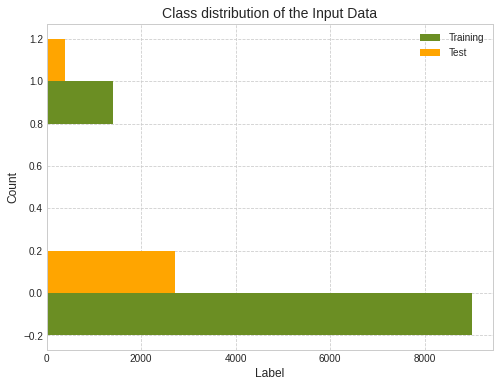

In [35]:
import numpy as np
import matplotlib.pyplot as plt
  
fig= plt.figure(figsize = (8, 6))
#plt.rcdefaults()
#fig, ax = plt.subplots()
 
x=y_train_win.value_counts()
z=y_test_win.value_counts()
plt.barh(x.index-0.1,x, color ='olivedrab',height=0.2,label='Training')
plt.barh(z.index+0.1,z, color ='orange',height=0.2, label='Test')

plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Class distribution of the Input Data", fontsize=14)
plt.grid(linestyle = '--')
plt.legend()
plt.savefig('imbalanced_class.png',dpi=400)
plt.show()

In [36]:
y_train_win.value_counts()/len(y_train_win)

0    0.864418
1    0.135582
Name: target_win, dtype: float64

In [37]:
y_test_win.value_counts()/len(y_test_win)

0    0.877142
1    0.122858
Name: target_win, dtype: float64

In [38]:
y_train_plc.value_counts()/len(y_train_plc)

0    0.593735
1    0.406265
Name: target_plc, dtype: float64

In [39]:
y_test_plc.value_counts()/len(y_test_plc)

0    0.630779
1    0.369221
Name: target_plc, dtype: float64

## Normalization

In [40]:
# standardization
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

## **Model 1: Logistic Regression**

In [41]:
# compare the difference with/without class_weight=balanced
compare={}

In [42]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()#class_weight='balanced'
logistic_reg.fit(X_train_sc, y_train_win)
y_pred_win_log = logistic_reg.predict(X_test_sc)

cm_win_log = confusion_matrix(y_test_win, y_pred_win_log, labels=[1, 0])
auc_win_log = roc_auc_score(y_test_win, y_pred_win_log)
acc_win_log = accuracy_score(y_test_win, y_pred_win_log)
f1_win_log = f1_score(y_test_win, y_pred_win_log, labels=[1, 0])
recall_win_log = recall_score(y_test_win, y_pred_win_log, labels=[1, 0])
precision_win_log = precision_score(y_test_win, y_pred_win_log, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of Logistic Regression:\n', cm_win_log)
print(f'The auc_score of Logistic Regression: {auc_win_log: .05f}')
print(f'The acc_score of Logistic Regression: {acc_win_log: .05f}')
print(f'The F-measure of Logistic Regression: {f1_win_log: .05f}')
print(f'The recall of Logistic Regression: {recall_win_log: .05f}')
print(f'The precision of Logistic Regression: {precision_win_log: .05f}')

compare['LR with equal weights'] = [cm_win_log, auc_win_log, acc_win_log, f1_win_log, recall_win_log, precision_win_log]

#win_models['LogisticRegression'] = [cm_win_log, auc_win_log, acc_win_log, f1_win_log, recall_win_log, precision_win_log]
#win_models['LogisticRegression'] = [cm_win_log, auc_win_log, acc_win_log, precision_win_log]

For predicting Win:
The confusion matrix of Logistic Regression:
 [[  79  301]
 [  62 2651]]
The auc_score of Logistic Regression:  0.59252
The acc_score of Logistic Regression:  0.88264
The F-measure of Logistic Regression:  0.30326
The recall of Logistic Regression:  0.20789
The precision of Logistic Regression:  0.56028


In [43]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(class_weight='balanced')#class_weight='balanced'
logistic_reg.fit(X_train_sc, y_train_win)
y_pred_win_log = logistic_reg.predict(X_test_sc)

cm_win_log = confusion_matrix(y_test_win, y_pred_win_log, labels=[1, 0])
auc_win_log = roc_auc_score(y_test_win, y_pred_win_log)
acc_win_log = accuracy_score(y_test_win, y_pred_win_log)
f1_win_log = f1_score(y_test_win, y_pred_win_log, labels=[1, 0])
recall_win_log = recall_score(y_test_win, y_pred_win_log, labels=[1, 0])
precision_win_log = precision_score(y_test_win, y_pred_win_log, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of Logistic Regression:\n', cm_win_log)
print(f'The auc_score of Logistic Regression: {auc_win_log: .05f}')
print(f'The acc_score of Logistic Regression: {acc_win_log: .05f}')
print(f'The F-measure of Logistic Regression: {f1_win_log: .05f}')
print(f'The recall of Logistic Regression: {recall_win_log: .05f}')
print(f'The precision of Logistic Regression: {precision_win_log: .05f}')

compare['LR with class weights']  = [cm_win_log, auc_win_log, acc_win_log, f1_win_log, recall_win_log, precision_win_log]
win_models['LogisticRegression'] = [cm_win_log, auc_win_log, acc_win_log, f1_win_log, recall_win_log, precision_win_log]

For predicting Win:
The confusion matrix of Logistic Regression:
 [[ 290   90]
 [ 380 2333]]
The auc_score of Logistic Regression:  0.81155
The acc_score of Logistic Regression:  0.84804
The F-measure of Logistic Regression:  0.55238
The recall of Logistic Regression:  0.76316
The precision of Logistic Regression:  0.43284


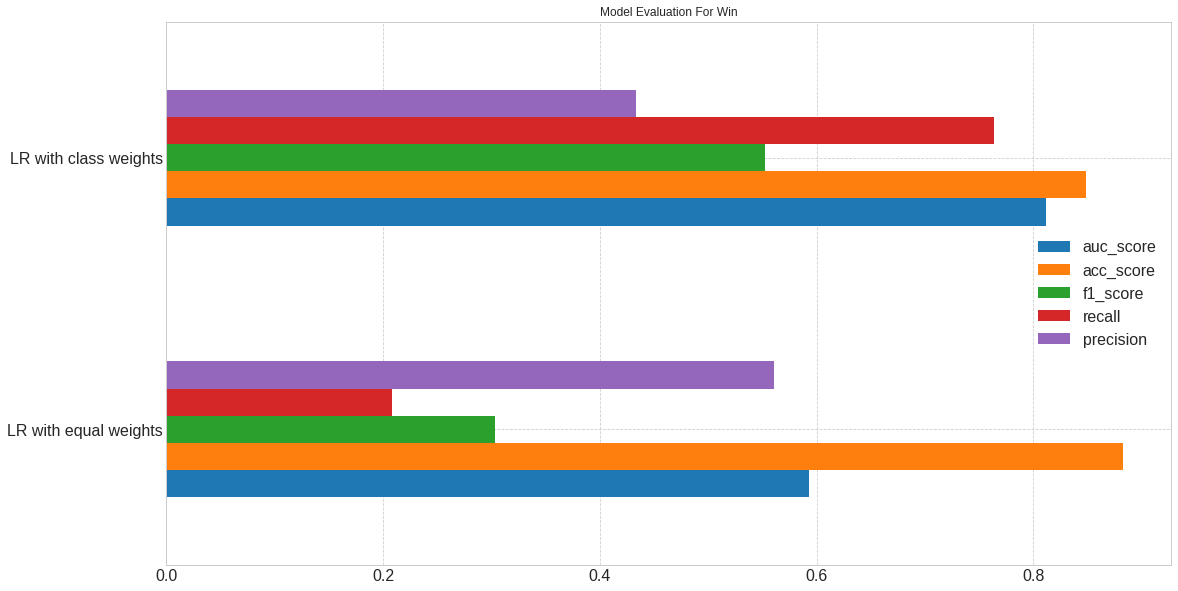

In [44]:
co=pd.DataFrame(compare.values(), index=compare.keys(), 
      columns=['confusion_matrix', 'auc_score', 'acc_score', 'f1_score',
          'recall', 'precision']).sort_values(by=['auc_score', 'f1_score'])
co.plot(kind='barh',figsize=(18,10),title='Model Evaluation For Win',fontsize=16)
plt.legend(loc=5, prop={'size': 16})
plt.grid(linestyle = '--')
plt.savefig('classweight_LR_comparision.png',dpi=400)
plt.show()

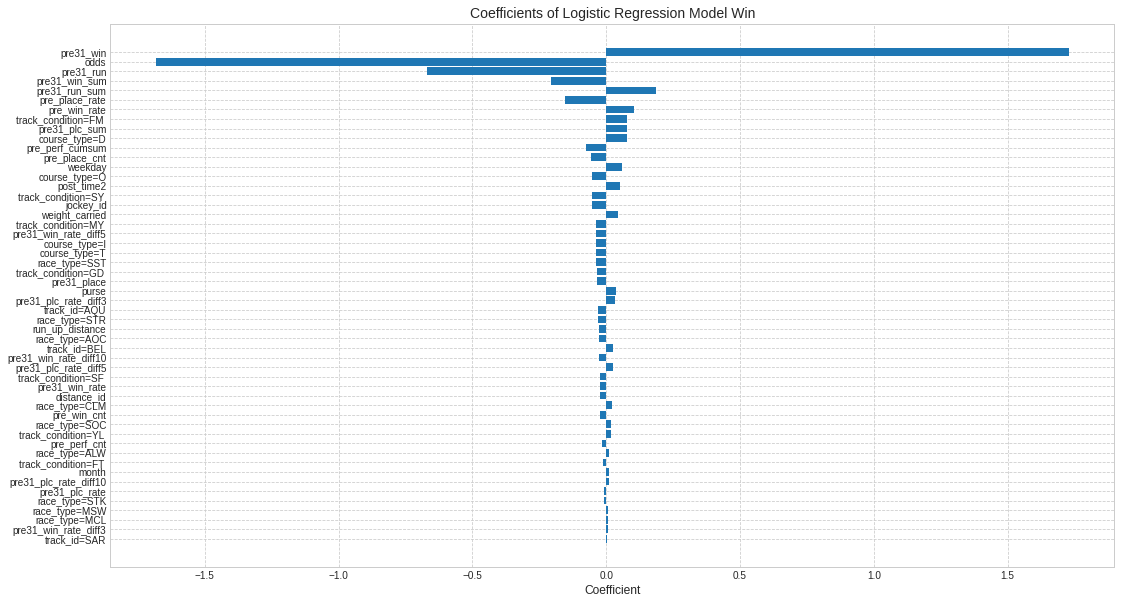

In [45]:
array=abs(logistic_reg.coef_.reshape(-1))
order = array.argsort()
fig= plt.figure(figsize = (18, 10))
plt.barh(X_train.columns[order],logistic_reg.coef_.reshape(-1)[order])
plt.xlabel("Coefficient", fontsize=12)
#plt.ylabel("Count", fontsize=12)
plt.title("Coefficients of Logistic Regression Model Win", fontsize=14)
plt.grid(linestyle = '--')
plt.savefig('interpretation_LR_Win.png',dpi=400)
plt.show()

In [46]:
logistic_reg = LogisticRegression(class_weight='balanced')
logistic_reg.fit(X_train_sc, y_train_plc)
y_pred_plc_log = logistic_reg.predict(X_test_sc)

cm_plc_log = confusion_matrix(y_test_plc, y_pred_plc_log, labels=[1, 0])
auc_plc_log = roc_auc_score(y_test_plc, y_pred_plc_log)
acc_plc_log = accuracy_score(y_test_plc, y_pred_plc_log)
f1_plc_log = f1_score(y_test_plc, y_pred_plc_log, labels=[1, 0])
recall_plc_log = recall_score(y_test_plc, y_pred_plc_log, labels=[1, 0])
precision_plc_log = precision_score(y_test_plc, y_pred_plc_log, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of Logistic Regression:\n', cm_plc_log)
print(f'The auc_score of Logistic Regression: {auc_plc_log: .05f}')
print(f'The acc_score of Logistic Regression: {acc_plc_log: .05f}')
print(f'The F-measure of Logistic Regression: {f1_plc_log: .05f}')
print(f'The recall of Logistic Regression: {recall_plc_log: .05f}')
print(f'The precision of Logistic Regression: {precision_plc_log: .05f}')

plc_models['LogisticRegression'] = [cm_plc_log, auc_plc_log, acc_plc_log, f1_plc_log, recall_plc_log, precision_plc_log]
#plc_models['LogisticRegression'] = [cm_plc_log, auc_plc_log, acc_plc_log, precision_plc_log]

For predicting Place:
The confusion matrix of Logistic Regression:
 [[ 768  374]
 [ 342 1609]]
The auc_score of Logistic Regression:  0.74860
The acc_score of Logistic Regression:  0.76851
The F-measure of Logistic Regression:  0.68206
The recall of Logistic Regression:  0.67250
The precision of Logistic Regression:  0.69189


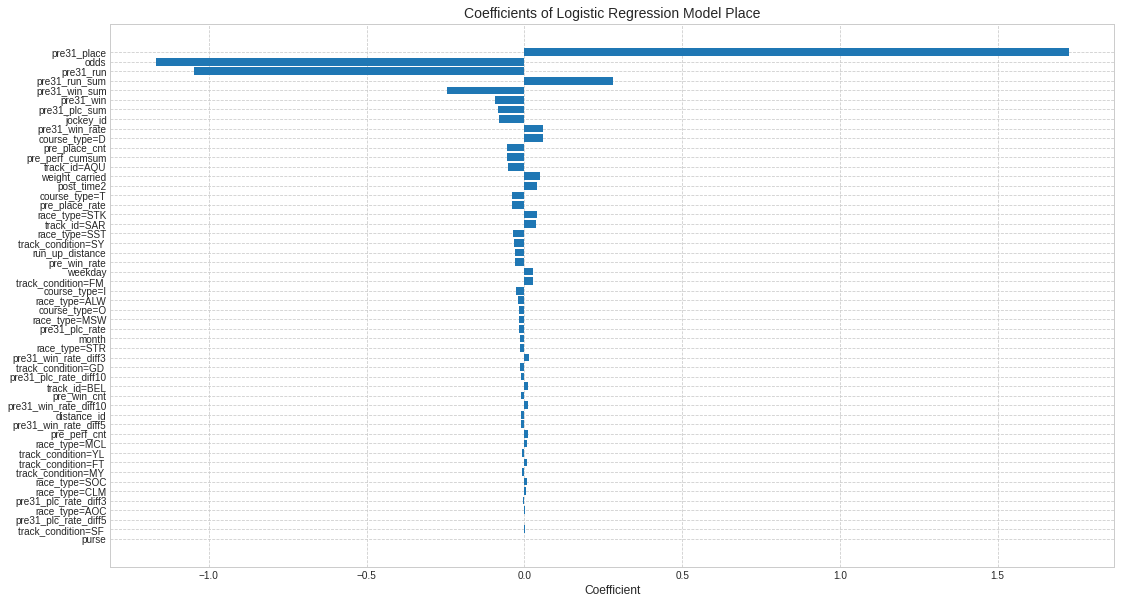

In [47]:
array=abs(logistic_reg.coef_.reshape(-1))
order = array.argsort()
fig= plt.figure(figsize = (18, 10))
plt.barh(X_train.columns[order],logistic_reg.coef_.reshape(-1)[order])
plt.xlabel("Coefficient", fontsize=12)
#plt.ylabel("Count", fontsize=12)
plt.title("Coefficients of Logistic Regression Model Place", fontsize=14)
plt.grid(linestyle = '--')
plt.savefig('interpretation_LR_Place.png',dpi=400)
plt.show()

## **Model 2: Support Vector Machines**

In [48]:
from sklearn.svm import LinearSVC

svm = LinearSVC(class_weight='balanced')
svm.fit(X_train_sc, y_train_win)
y_pred_win_svm = svm.predict(X_test_sc)

cm_win_svm = confusion_matrix(y_test_win, y_pred_win_svm, labels=[1, 0])
auc_win_svm = roc_auc_score(y_test_win, y_pred_win_svm)
acc_win_svm = accuracy_score(y_test_win, y_pred_win_svm)
f1_win_svm = f1_score(y_test_win, y_pred_win_svm, labels=[1, 0])
recall_win_svm = recall_score(y_test_win, y_pred_win_svm, labels=[1, 0])
precision_win_svm = precision_score(y_test_win, y_pred_win_svm, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of SVM:\n', cm_win_svm)
print(f'The auc_score of SVM: {auc_win_svm: .05f}')
print(f'The acc_score of SVM: {acc_win_svm: .05f}')
print(f'The F-measure of SVM: {f1_win_svm: .05f}')
print(f'The recall of SVM: {recall_win_svm: .05f}')
print(f'The precision of SVM: {precision_win_svm: .05f}')

win_models['SVM'] = [cm_win_svm, auc_win_svm, acc_win_svm, f1_win_svm, recall_win_svm, precision_win_svm]
#win_models['SVM'] = [cm_win_svm, auc_win_svm, acc_win_svm, precision_win_svm]

For predicting Win:
The confusion matrix of SVM:
 [[ 286   94]
 [ 373 2340]]
The auc_score of SVM:  0.80757
The acc_score of SVM:  0.84901
The F-measure of SVM:  0.55053
The recall of SVM:  0.75263
The precision of SVM:  0.43399


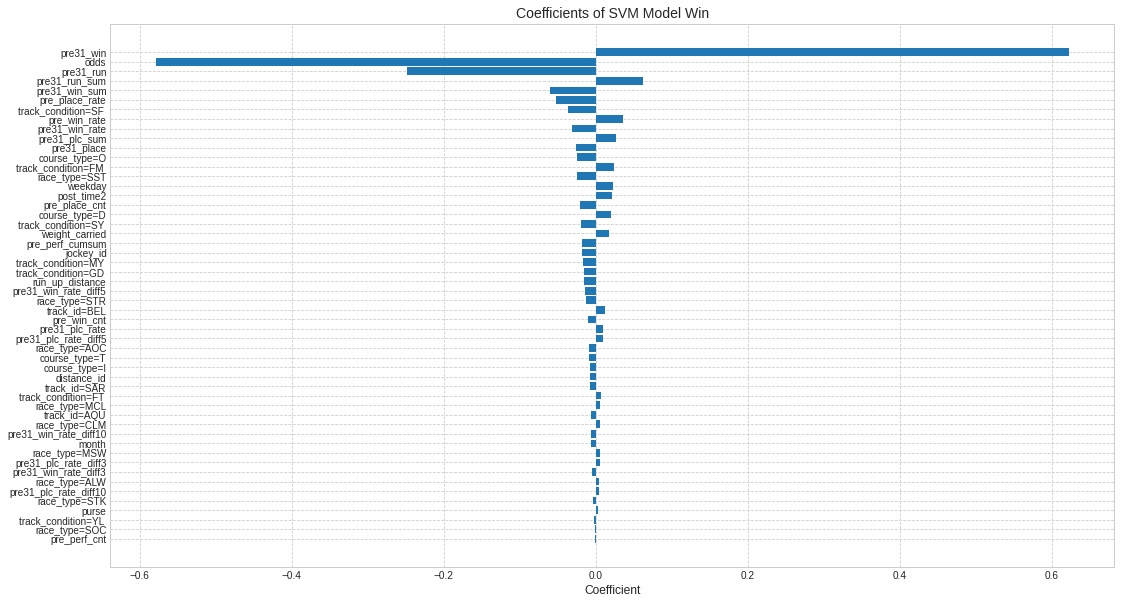

In [49]:
array=abs(svm.coef_.reshape(-1))
order = array.argsort()
fig= plt.figure(figsize = (18, 10))
plt.barh(X_train.columns[order],svm.coef_.reshape(-1)[order])
plt.xlabel("Coefficient", fontsize=12)
#plt.ylabel("Count", fontsize=12)
plt.title("Coefficients of SVM Model Win", fontsize=14)
plt.grid(linestyle = '--')
plt.savefig('interpretation_SVM_Win.png',dpi=400)
plt.show()

In [50]:
svm = LinearSVC(class_weight='balanced')
svm.fit(X_train_sc, y_train_plc)
y_pred_plc_svm = svm.predict(X_test_sc)

cm_plc_svm = confusion_matrix(y_test_plc, y_pred_plc_svm, labels=[1, 0])
auc_plc_svm = roc_auc_score(y_test_plc, y_pred_plc_svm)
acc_plc_svm = accuracy_score(y_test_plc, y_pred_plc_svm)
f1_plc_svm = f1_score(y_test_plc, y_pred_plc_svm, labels=[1, 0])
recall_plc_svm = recall_score(y_test_plc, y_pred_plc_svm, labels=[1, 0])
precision_plc_svm = precision_score(y_test_plc, y_pred_plc_svm, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of SVM:\n', cm_plc_svm)
print(f'The auc_score of SVM: {auc_plc_svm: .05f}')
print(f'The acc_score of SVM: {acc_plc_svm: .05f}')
print(f'The F-measure of SVM: {f1_plc_svm: .05f}')
print(f'The recall of SVM: {recall_plc_svm: .05f}')
print(f'The precision of SVM: {precision_plc_svm: .05f}')

plc_models['SVM'] = [cm_plc_svm, auc_plc_svm, acc_plc_svm, f1_plc_svm, recall_plc_svm, precision_plc_svm]
#plc_models['SVM'] = [cm_plc_svm, auc_plc_svm, acc_plc_svm, precision_plc_svm]

For predicting Place:
The confusion matrix of SVM:
 [[ 777  365]
 [ 352 1599]]
The auc_score of SVM:  0.74998
The acc_score of SVM:  0.76819
The F-measure of SVM:  0.68428
The recall of SVM:  0.68039
The precision of SVM:  0.68822


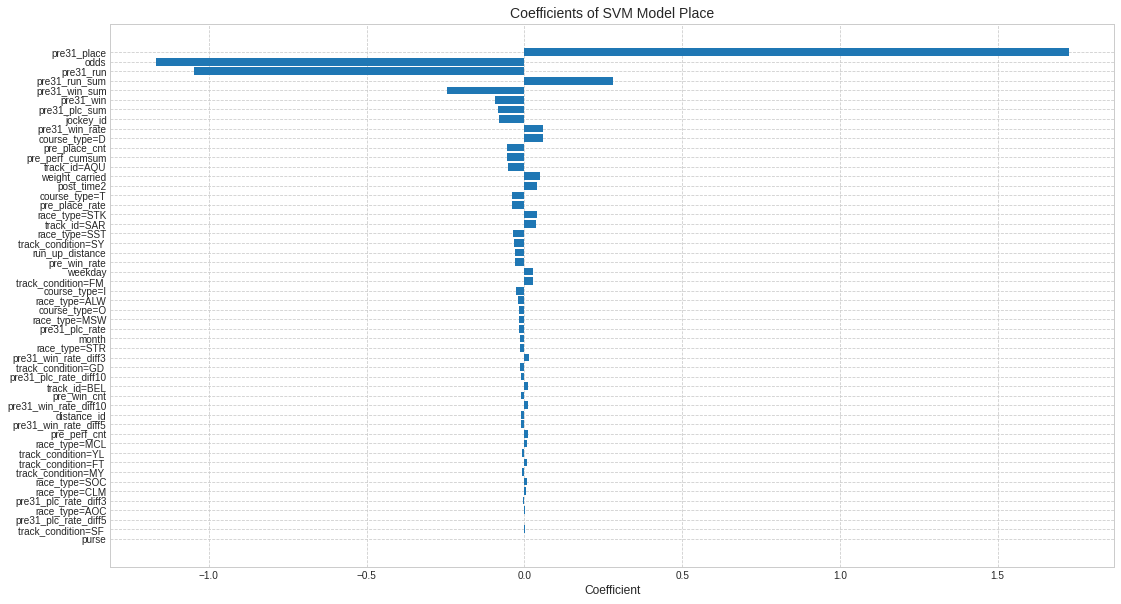

In [51]:
array=abs(logistic_reg.coef_.reshape(-1))
order = array.argsort()
fig= plt.figure(figsize = (18, 10))
plt.barh(X_train.columns[order],logistic_reg.coef_.reshape(-1)[order])
plt.xlabel("Coefficient", fontsize=12)
#plt.ylabel("Count", fontsize=12)
plt.title("Coefficients of SVM Model Place", fontsize=14)
plt.grid(linestyle = '--')
plt.savefig('interpretation_SVM_Place.png',dpi=400)
plt.show()

## **Model 3: Decision Trees**


In [52]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(criterion='entropy')
dec_tree.fit(X_train, y_train_win)
y_pred_win_dt = dec_tree.predict(X_test)

cm_win_dt = confusion_matrix(y_test_win, y_pred_win_dt, labels=[1, 0])
auc_win_dt = roc_auc_score(y_test_win, y_pred_win_dt)
acc_win_dt = accuracy_score(y_test_win, y_pred_win_dt)
f1_win_dt = f1_score(y_test_win, y_pred_win_dt, labels=[1, 0])
recall_win_dt = recall_score(y_test_win, y_pred_win_dt, labels=[1, 0])
precision_win_dt = precision_score(y_test_win, y_pred_win_dt, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of Decision Trees:\n', cm_win_dt)
print(f'The auc_score of Decision Trees: {auc_win_dt: .05f}')
print(f'The acc_score of Decision Trees: {acc_win_dt: .05f}')
print(f'The F-measure of Decision Trees: {f1_win_dt: .05f}')
print(f'The recall of Decision Trees: {recall_win_dt: .05f}')
print(f'The precision of Decision Trees: {precision_win_dt: .05f}')

win_models['DecisionTrees'] = [cm_win_dt, auc_win_dt, acc_win_dt, f1_win_dt, recall_win_dt, precision_win_dt]
#win_models['DecisionTrees'] = [cm_win_dt, auc_win_dt, acc_win_dt, precision_win_dt]

For predicting Win:
The confusion matrix of Decision Trees:
 [[ 192  188]
 [ 243 2470]]
The auc_score of Decision Trees:  0.70785
The acc_score of Decision Trees:  0.86065
The F-measure of Decision Trees:  0.47117
The recall of Decision Trees:  0.50526
The precision of Decision Trees:  0.44138


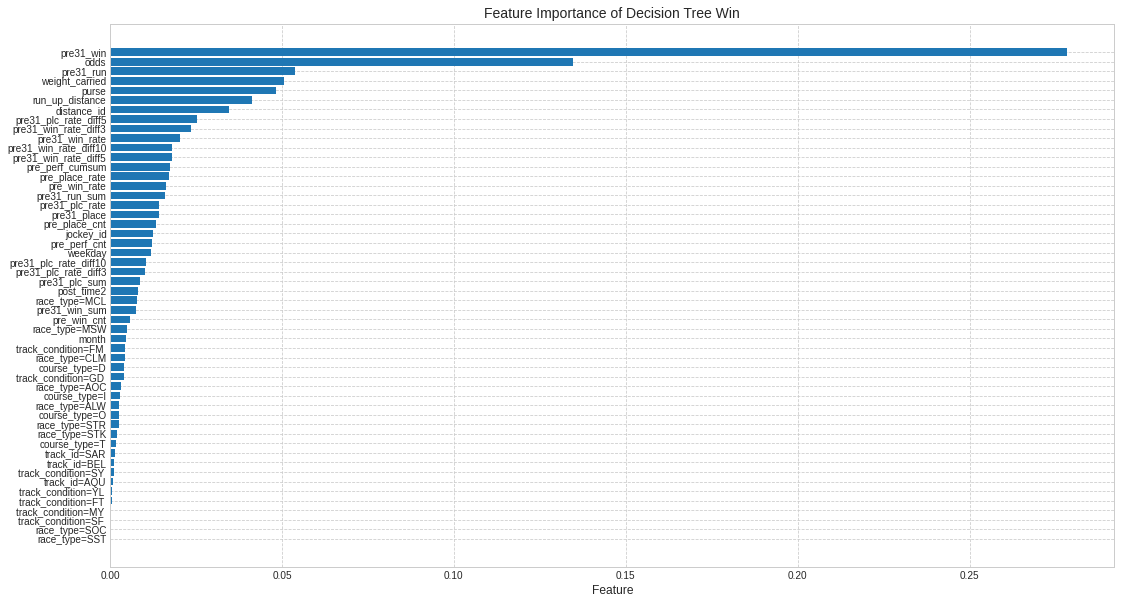

In [53]:
array=abs(dec_tree.feature_importances_)
order = array.argsort()
fig= plt.figure(figsize = (18, 10))
plt.barh(X_train.columns[order],dec_tree.feature_importances_[order])
plt.xlabel("Feature", fontsize=12)
#plt.ylabel("Count", fontsize=12)
plt.title("Feature Importance of Decision Tree Win", fontsize=14)
plt.grid(linestyle = '--')
plt.savefig('FeatureImportance_DT_Win.png',dpi=400)
plt.show()

In [54]:
dec_tree = DecisionTreeClassifier(criterion='entropy')#DecisionTreeClassifier(criterion='gini')
dec_tree.fit(X_train, y_train_plc)
y_pred_plc_dt = dec_tree.predict(X_test)

cm_plc_dt = confusion_matrix(y_test_plc, y_pred_plc_dt, labels=[1, 0])
auc_plc_dt = roc_auc_score(y_test_plc, y_pred_plc_dt)
acc_plc_dt = accuracy_score(y_test_plc, y_pred_plc_dt)
f1_plc_dt = f1_score(y_test_plc, y_pred_plc_dt, labels=[1, 0])
recall_plc_dt = recall_score(y_test_plc, y_pred_plc_dt, labels=[1, 0])
precision_plc_dt = precision_score(y_test_plc, y_pred_plc_dt, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of Decision Trees:\n', cm_plc_dt)
print(f'The auc_score of Decision Trees: {auc_plc_dt: .05f}')
print(f'The acc_score of Decision Trees: {acc_plc_dt: .05f}')
print(f'The F-measure of Decision Trees: {f1_plc_dt: .05f}')
print(f'The recall of Decision Trees: {recall_plc_dt: .05f}')
print(f'The precision of Decision Trees: {precision_plc_dt: .05f}')

plc_models['DecisionTree'] = [cm_plc_dt, auc_plc_dt, acc_plc_dt, f1_plc_dt, recall_plc_dt, precision_plc_dt]
#plc_models['DecisionTree'] = [cm_plc_dt, auc_plc_dt, acc_plc_dt, precision_plc_dt]

For predicting Place:
The confusion matrix of Decision Trees:
 [[ 701  441]
 [ 436 1515]]
The auc_score of Decision Trees:  0.69518
The acc_score of Decision Trees:  0.71646
The F-measure of Decision Trees:  0.61518
The recall of Decision Trees:  0.61384
The precision of Decision Trees:  0.61653


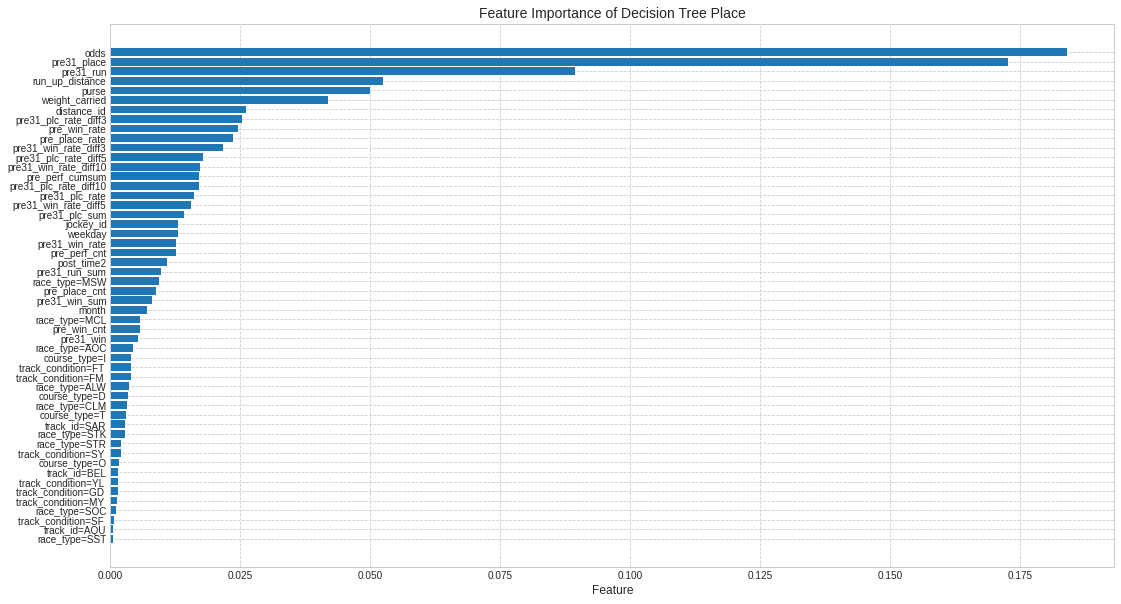

In [55]:
array=abs(dec_tree.feature_importances_)
order = array.argsort()
fig= plt.figure(figsize = (18, 10))
plt.barh(X_train.columns[order],dec_tree.feature_importances_[order])
plt.xlabel("Feature", fontsize=12)
#plt.ylabel("Count", fontsize=12)
plt.title("Feature Importance of Decision Tree Place", fontsize=14)
plt.grid(linestyle = '--')
plt.savefig('FeatureImportance_DT_Place.png',dpi=400)
plt.show()

## **Model 4: Random Forest**

In [56]:
from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train_win)
y_pred_win_rf = rand_forest.predict(X_test)

cm_win_rf = confusion_matrix(y_test_win, y_pred_win_rf, labels=[1, 0])
auc_win_rf = roc_auc_score(y_test_win, y_pred_win_rf)
acc_win_rf = accuracy_score(y_test_win, y_pred_win_rf)
f1_win_rf = f1_score(y_test_win, y_pred_win_rf, labels=[1, 0])
recall_win_rf = recall_score(y_test_win, y_pred_win_rf, labels=[1, 0])
precision_win_rf = precision_score(y_test_win, y_pred_win_rf, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of Random Forest:\n', cm_win_rf)
print(f'The auc_score of Random Forest: {auc_win_rf: .05f}')
print(f'The acc_score of Random Forest: {acc_win_rf: .05f}')
print(f'The F-measure of Random Forest: {f1_win_rf: .05f}')
print(f'The recall of Random Forest: {recall_win_rf: .05f}')
print(f'The precision of Random Forest: {precision_win_rf: .05f}')

win_models['RandomForest'] = [cm_win_rf, auc_win_rf, acc_win_rf, f1_win_rf, recall_win_rf, precision_win_rf]

For predicting Win:
The confusion matrix of Random Forest:
 [[  84  296]
 [  29 2684]]
The auc_score of Random Forest:  0.60518
The acc_score of Random Forest:  0.89492
The F-measure of Random Forest:  0.34077
The recall of Random Forest:  0.22105
The precision of Random Forest:  0.74336


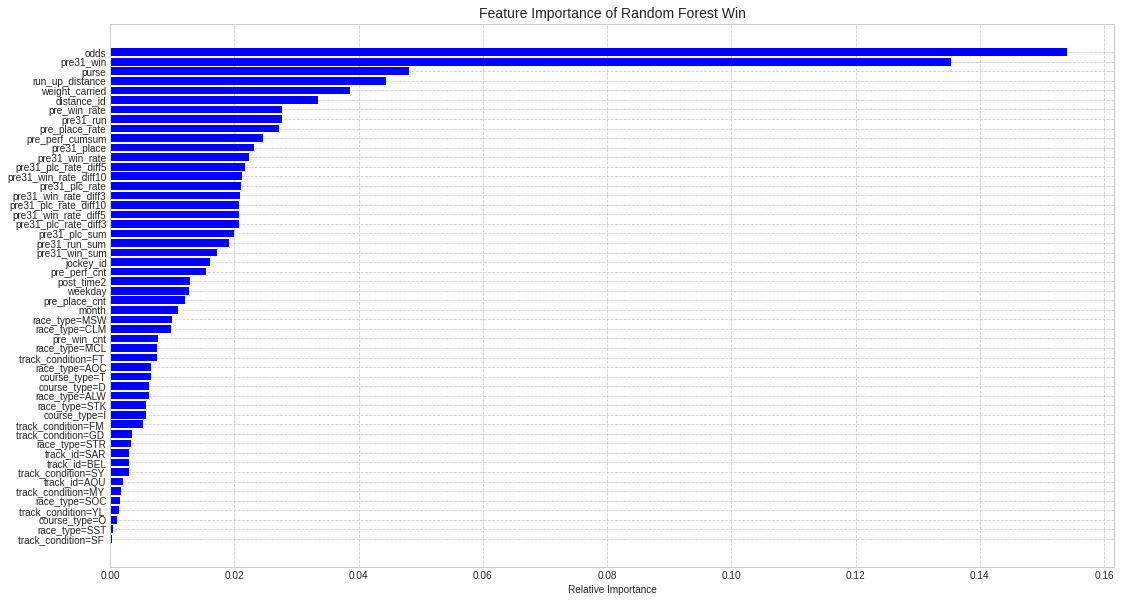

In [57]:
features = X_train.columns
importances = rand_forest.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize = (18, 10))

plt.title('Feature Importance of Random Forest Win', fontsize=14)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
#plt.ylabel("Count", fontsize=12)
plt.grid(linestyle = '--')
plt.savefig('FeatureImportance_RF_Win.png',dpi=400)
plt.show()

In [58]:
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train_plc)
y_pred_plc_rf = rand_forest.predict(X_test)

cm_plc_rf = confusion_matrix(y_test_plc, y_pred_plc_rf, labels=[1, 0])
auc_plc_rf = roc_auc_score(y_test_plc, y_pred_plc_rf)
acc_plc_rf = accuracy_score(y_test_plc, y_pred_plc_rf)
f1_plc_rf = f1_score(y_test_plc, y_pred_plc_rf, labels=[1, 0])
recall_plc_rf = recall_score(y_test_plc, y_pred_plc_rf, labels=[1, 0])
precision_plc_rf = precision_score(y_test_plc, y_pred_plc_rf, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of Random Forest:\n', cm_plc_rf)
print(f'The auc_score of Random Forest: {auc_plc_rf: .05f}')
print(f'The acc_score of Random Forest: {acc_plc_rf: .05f}')
print(f'The F-measure of Random Forest: {f1_plc_rf: .05f}')
print(f'The recall of Random Forest: {recall_plc_rf: .05f}')
print(f'The precision of Random Forest: {precision_plc_rf: .05f}')

plc_models['RandomForest'] = [cm_plc_rf, auc_plc_rf, acc_plc_rf, f1_plc_rf, recall_plc_rf, precision_plc_rf]

For predicting Place:
The confusion matrix of Random Forest:
 [[ 727  415]
 [ 317 1634]]
The auc_score of Random Forest:  0.73706
The acc_score of Random Forest:  0.76334
The F-measure of Random Forest:  0.66514
The recall of Random Forest:  0.63660
The precision of Random Forest:  0.69636


In [59]:
importances = rand_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in rand_forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

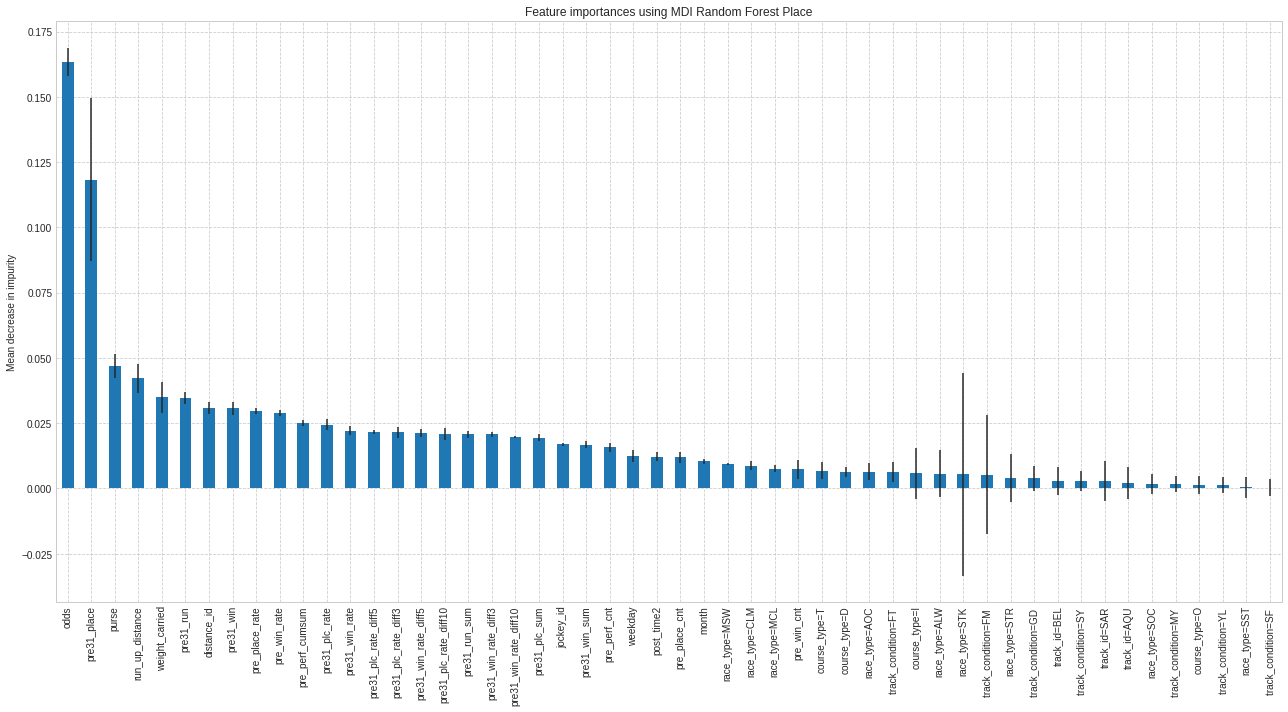

In [60]:
import pandas as pd

forest_importances = pd.Series(importances[indices], index=X_train.columns[indices])
#fig= plt.figure(figsize = (18, 10))
fig, ax = plt.subplots(figsize = (18, 10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI Random Forest Place")
ax.set_ylabel("Mean decrease in impurity")
plt.grid(linestyle = '--')
plt.savefig('FeatureImportance_RF_Place.png',dpi=400)
fig.tight_layout()

## **Model 5: Naive Bayes**

In [61]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(X_train_sc, y_train_win)
y_pred_win_nb = naive_bayes.predict(X_test_sc)

cm_win_nb = confusion_matrix(y_test_win, y_pred_win_nb, labels=[1, 0])
auc_win_nb = roc_auc_score(y_test_win, y_pred_win_nb)
acc_win_nb = accuracy_score(y_test_win, y_pred_win_nb)
f1_win_nb = f1_score(y_test_win, y_pred_win_nb, labels=[1, 0])
recall_win_nb = recall_score(y_test_win, y_pred_win_nb, labels=[1, 0])
precision_win_nb = precision_score(y_test_win, y_pred_win_nb, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of Naive Bayes:\n', cm_win_nb)
print(f'The auc_score of Naive Bayes: {auc_win_nb: .05f}')
print(f'The acc_score of Naive Bayes: {acc_win_nb: .05f}')
print(f'The F-measure of Naive Bayes: {f1_win_nb: .05f}')
print(f'The recall of Naive Bayes: {recall_win_nb: .05f}')
print(f'The precision of Naive Bayes: {precision_win_nb: .05f}')

win_models['NaiveBayes'] = [cm_win_nb, auc_win_nb, acc_win_nb, f1_win_nb, recall_win_nb, precision_win_nb]

For predicting Win:
The confusion matrix of Naive Bayes:
 [[ 208  172]
 [ 494 2219]]
The auc_score of Naive Bayes:  0.68264
The acc_score of Naive Bayes:  0.78468
The F-measure of Naive Bayes:  0.38447
The recall of Naive Bayes:  0.54737
The precision of Naive Bayes:  0.29630


In [62]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train_plc)
y_pred_plc_nb = naive_bayes.predict(X_test)

cm_plc_nb = confusion_matrix(y_test_plc, y_pred_plc_nb, labels=[1, 0])
auc_plc_nb = roc_auc_score(y_test_plc, y_pred_plc_nb)
acc_plc_nb = accuracy_score(y_test_plc, y_pred_plc_nb)
f1_plc_nb = f1_score(y_test_plc, y_pred_plc_nb, labels=[1, 0])
recall_plc_nb = recall_score(y_test_plc, y_pred_plc_nb, labels=[1, 0])
precision_plc_nb = precision_score(y_test_plc, y_pred_plc_nb, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of Naive Bayes:\n', cm_plc_nb)
print(f'The auc_score of Naive Bayes: {auc_plc_nb: .05f}')
print(f'The acc_score of Naive Bayes: {acc_plc_nb: .05f}')
print(f'The F-measure of Naive Bayes: {f1_plc_nb: .05f}')
print(f'The recall of Naive Bayes: {recall_plc_nb: .05f}')
print(f'The precision of Naive Bayes: {precision_plc_nb: .05f}')

plc_models['NaiveBayes'] = [cm_plc_nb, auc_plc_nb, acc_plc_nb, f1_plc_nb, recall_plc_nb, precision_plc_nb]

For predicting Place:
The confusion matrix of Naive Bayes:
 [[ 860  282]
 [ 870 1081]]
The auc_score of Naive Bayes:  0.65357
The acc_score of Naive Bayes:  0.62755
The F-measure of Naive Bayes:  0.59889
The recall of Naive Bayes:  0.75306
The precision of Naive Bayes:  0.49711


## **Model 6: K-Nearest Neighbors**

In [63]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_sc, y_train_win)
y_pred_win_knn = knn.predict(X_test_sc)

cm_win_knn = confusion_matrix(y_test_win, y_pred_win_knn, labels=[1, 0])
auc_win_knn = roc_auc_score(y_test_win, y_pred_win_knn)
acc_win_knn = accuracy_score(y_test_win, y_pred_win_knn)
f1_win_knn = f1_score(y_test_win, y_pred_win_knn, labels=[1, 0])
recall_win_knn = recall_score(y_test_win, y_pred_win_knn, labels=[1, 0])
precision_win_knn = precision_score(y_test_win, y_pred_win_knn, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of KNN:\n', cm_win_knn)
print(f'The auc_score of KNN: {auc_win_knn: .05f}')
print(f'The acc_score of KNN: {acc_win_knn: .05f}')
print(f'The F-measure of KNN: {f1_win_knn: .05f}')
print(f'The recall of KNN: {recall_win_knn: .05f}')
print(f'The precision of KNN: {precision_win_knn: .05f}')

win_models['KNN'] = [cm_win_knn, auc_win_knn, acc_win_knn, f1_win_knn, recall_win_knn, precision_win_knn]

For predicting Win:
The confusion matrix of KNN:
 [[  24  356]
 [  31 2682]]
The auc_score of KNN:  0.52587
The acc_score of KNN:  0.87488
The F-measure of KNN:  0.11034
The recall of KNN:  0.06316
The precision of KNN:  0.43636


In [64]:
knn = KNeighborsClassifier()
knn.fit(X_train_sc, y_train_plc)
y_pred_plc_knn = knn.predict(X_test_sc)

cm_plc_knn = confusion_matrix(y_test_plc, y_pred_plc_knn, labels=[1, 0])
auc_plc_knn = roc_auc_score(y_test_plc, y_pred_plc_knn)
acc_plc_knn = accuracy_score(y_test_plc, y_pred_plc_knn)
f1_plc_knn = f1_score(y_test_plc, y_pred_plc_knn, labels=[1, 0])
recall_plc_knn = recall_score(y_test_plc, y_pred_plc_knn, labels=[1, 0])
precision_plc_knn = precision_score(y_test_plc, y_pred_plc_knn, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of KNN:\n', cm_plc_knn)
print(f'The auc_score of KNN: {auc_plc_knn: .05f}')
print(f'The acc_score of KNN: {acc_plc_knn: .05f}')
print(f'The F-measure of KNN: {f1_plc_knn: .05f}')
print(f'The recall of KNN: {recall_plc_knn: .05f}')
print(f'The precision of KNN: {precision_plc_knn: .05f}')

plc_models['KNN'] = [cm_plc_knn, auc_plc_knn, acc_plc_knn, f1_plc_knn, recall_plc_knn, precision_plc_knn]

For predicting Place:
The confusion matrix of KNN:
 [[ 518  624]
 [ 483 1468]]
The auc_score of KNN:  0.60301
The acc_score of KNN:  0.64210
The F-measure of KNN:  0.48343
The recall of KNN:  0.45359
The precision of KNN:  0.51748


## **Model 7: ANN**

In [65]:
from keras.models import Sequential
from keras.layers import Dense

def prob_threshold(array):
  y_pred = []
  for i in range(len(array)):
    y_pred.append(1) if array[i] >= 0.5 else y_pred.append(0)
  return y_pred

def ann_classification(Optimizer_Trial, Neurons_Trial):
  classifier = Sequential()
  classifier.add(Dense(units=Neurons_Trial, input_dim=len(features), kernel_initializer='uniform', activation='relu'))
  classifier.add(Dense(units=Neurons_Trial, kernel_initializer='uniform', activation='relu'))
  classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
  classifier.compile(optimizer=Optimizer_Trial, loss='binary_crossentropy', metrics=['AUC'])            
  return classifier

ann = ann_classification('adam', 15)
ann.fit(X_train_sc, y_train_win, batch_size=30, epochs=50, verbose=1)
y_preds_win_ann = ann.predict(X_test_sc)
auc_win_ann = roc_auc_score(y_test_win, y_preds_win_ann)
y_preds_win_ann = prob_threshold(y_preds_win_ann)
cm_win_ann = confusion_matrix(y_test_win, y_preds_win_ann, labels=[1, 0])
acc_win_ann = accuracy_score(y_test_win, y_preds_win_ann)
f1_win_ann = f1_score(y_test_win, y_preds_win_ann, labels=[1, 0])
recall_win_ann = recall_score(y_test_win, y_preds_win_ann, labels=[1, 0])
precision_win_ann = precision_score(y_test_win, y_preds_win_ann, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of ANN:\n', cm_win_ann)
print(f'The auc_score of ANN: {auc_win_ann: .05f}')
print(f'The acc_score of ANN: {acc_win_ann: .05f}')
print(f'The F-measure of ANN: {f1_win_ann: .05f}')
print(f'The recall of ANN: {recall_win_ann: .05f}')
print(f'The precision of ANN: {precision_win_ann: .05f}')

#win_models['ANN'] = [cm_win_ann, auc_win_ann, acc_win_ann, f1_win_ann, recall_win_ann, precision_win_ann]

Epoch 1/50
347/347 [==============================] - 5s 3ms/step - loss: 0.4067 - auc: 0.6672
Epoch 2/50
347/347 [==============================] - 1s 3ms/step - loss: 0.2898 - auc: 0.8594
Epoch 3/50
347/347 [==============================] - 1s 3ms/step - loss: 0.2705 - auc: 0.8772
Epoch 4/50
347/347 [==============================] - 1s 3ms/step - loss: 0.2636 - auc: 0.8853
Epoch 5/50
347/347 [==============================] - 1s 3ms/step - loss: 0.2598 - auc: 0.8892
Epoch 6/50
347/347 [==============================] - 1s 3ms/step - loss: 0.2573 - auc: 0.8923
Epoch 7/50
347/347 [==============================] - 1s 3ms/step - loss: 0.2562 - auc: 0.8933
Epoch 8/50
347/347 [==============================] - 1s 3ms/step - loss: 0.2540 - auc: 0.8953
Epoch 9/50
347/347 [==============================] - 1s 3ms/step - loss: 0.2526 - auc: 0.8973
Epoch 10/50
347/347 [==============================] - 1s 3ms/step - loss: 0.2523 - auc: 0.8972
Epoch 11/50
347/347 [============================

In [66]:
from keras.models import Sequential
from keras.layers import Dense

def prob_threshold(array):
  y_pred = []
  for i in range(len(array)):
    y_pred.append(1) if array[i] >= 0.5 else y_pred.append(0)
  return y_pred

def ann_classification(Optimizer_Trial, Neurons_Trial):
  classifier = Sequential()
  classifier.add(Dense(units=Neurons_Trial, input_dim=len(features), kernel_initializer='uniform', activation='relu'))
  classifier.add(Dense(units=Neurons_Trial, kernel_initializer='uniform', activation='relu'))
  classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
  classifier.compile(optimizer=Optimizer_Trial, loss='binary_crossentropy', metrics=['AUC'])            
  return classifier

ann = ann_classification('adam', 15)
ann.fit(X_train, y_train_win, batch_size=100, epochs=20, verbose=1)
y_preds_win_ann = ann.predict(X_test)
auc_win_ann = roc_auc_score(y_test_win, y_preds_win_ann)
y_preds_win_ann = prob_threshold(y_preds_win_ann)
cm_win_ann = confusion_matrix(y_test_win, y_preds_win_ann, labels=[1, 0])
acc_win_ann = accuracy_score(y_test_win, y_preds_win_ann)
f1_win_ann = f1_score(y_test_win, y_preds_win_ann, labels=[1, 0])
recall_win_ann = recall_score(y_test_win, y_preds_win_ann, labels=[1, 0])
precision_win_ann = precision_score(y_test_win, y_preds_win_ann, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of ANN:\n', cm_win_ann)
print(f'The auc_score of ANN: {auc_win_ann: .05f}')
print(f'The acc_score of ANN: {acc_win_ann: .05f}')
print(f'The F-measure of ANN: {f1_win_ann: .05f}')
print(f'The recall of ANN: {recall_win_ann: .05f}')
print(f'The precision of ANN: {precision_win_ann: .05f}')

win_models['ANN'] = [cm_win_ann, auc_win_ann, acc_win_ann, f1_win_ann, recall_win_ann, precision_win_ann]

Epoch 1/20
105/105 [==============================] - 1s 3ms/step - loss: 0.6993 - auc: 0.5631
Epoch 2/20
105/105 [==============================] - 0s 3ms/step - loss: 0.4084 - auc: 0.6748
Epoch 3/20
105/105 [==============================] - 0s 3ms/step - loss: 0.3674 - auc: 0.7288
Epoch 4/20
105/105 [==============================] - 0s 3ms/step - loss: 0.3598 - auc: 0.7354
Epoch 5/20
105/105 [==============================] - 0s 3ms/step - loss: 0.3535 - auc: 0.7494
Epoch 6/20
105/105 [==============================] - 0s 3ms/step - loss: 0.3655 - auc: 0.7259
Epoch 7/20
105/105 [==============================] - 0s 3ms/step - loss: 0.3676 - auc: 0.7232
Epoch 8/20
105/105 [==============================] - 0s 3ms/step - loss: 0.3599 - auc: 0.7458
Epoch 9/20
105/105 [==============================] - 0s 3ms/step - loss: 0.3786 - auc: 0.7191
Epoch 10/20
105/105 [==============================] - 0s 3ms/step - loss: 0.3499 - auc: 0.7571
Epoch 11/20
105/105 [============================

In [67]:
ann = ann_classification('adam', 15)
ann.fit(X_train, y_train_plc, batch_size=100, epochs=20, verbose=1)
y_preds_plc_ann = ann.predict(X_test)
auc_plc_ann = roc_auc_score(y_test_plc, y_preds_plc_ann)
y_preds_plc_ann = prob_threshold(y_preds_plc_ann)
cm_plc_ann = confusion_matrix(y_test_plc, y_preds_plc_ann, labels=[1, 0])
acc_plc_ann = accuracy_score(y_test_plc, y_preds_plc_ann)
f1_plc_ann = f1_score(y_test_plc, y_preds_plc_ann, labels=[1, 0])
recall_plc_ann = recall_score(y_test_plc, y_preds_plc_ann, labels=[1, 0])
precision_plc_ann = precision_score(y_test_plc, y_preds_plc_ann, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of ANN:\n', cm_plc_ann)
print(f'The auc_score of ANN: {auc_plc_ann: .05f}')
print(f'The acc_score of ANN: {acc_plc_ann: .05f}')
print(f'The F-measure of ANN: {f1_plc_ann: .05f}')
print(f'The recall of ANN: {recall_plc_ann: .05f}')
print(f'The precision of ANN: {precision_plc_ann: .05f}')

plc_models['ANN'] = [cm_plc_ann, auc_plc_ann, acc_plc_ann, f1_plc_ann, recall_plc_ann, precision_plc_ann]

Epoch 1/20
105/105 [==============================] - 1s 3ms/step - loss: 1.3015 - auc: 0.5721
Epoch 2/20
105/105 [==============================] - 0s 3ms/step - loss: 0.6311 - auc: 0.6899
Epoch 3/20
105/105 [==============================] - 0s 3ms/step - loss: 0.6116 - auc: 0.7165
Epoch 4/20
105/105 [==============================] - 0s 3ms/step - loss: 0.6369 - auc: 0.6944
Epoch 5/20
105/105 [==============================] - 0s 3ms/step - loss: 0.6169 - auc: 0.7110
Epoch 6/20
105/105 [==============================] - 0s 3ms/step - loss: 0.6062 - auc: 0.7223
Epoch 7/20
105/105 [==============================] - 0s 3ms/step - loss: 0.6122 - auc: 0.7138
Epoch 8/20
105/105 [==============================] - 0s 3ms/step - loss: 0.6163 - auc: 0.7127
Epoch 9/20
105/105 [==============================] - 0s 3ms/step - loss: 0.6140 - auc: 0.7205
Epoch 10/20
105/105 [==============================] - 0s 3ms/step - loss: 0.6009 - auc: 0.7282
Epoch 11/20
105/105 [============================

## **Model 8: LightGBM**



### **Predict with default setting baseline**

In [68]:
import lightgbm as ltb

lgb = ltb.LGBMClassifier(class_weight='balanced')
lgb.fit(X_train, y_train_win)
y_pred_win_lgb = lgb.predict(X_test)

cm_win_lgb = confusion_matrix(y_test_win, y_pred_win_lgb, labels=[1, 0])
auc_win_lgb = roc_auc_score(y_test_win, y_pred_win_lgb)
acc_win_lgb = accuracy_score(y_test_win, y_pred_win_lgb)
f1_win_lgb= f1_score(y_test_win, y_pred_win_lgb, labels=[1, 0])
recall_win_lgb = recall_score(y_test_win, y_pred_win_lgb, labels=[1, 0])
precision_win_lgb= precision_score(y_test_win, y_pred_win_lgb, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of LGB:\n', cm_win_lgb)
print(f'The auc_score of LGB: {auc_win_lgb: .05f}')
print(f'The acc_score of LGB: {acc_win_lgb: .05f}')
print(f'The F-measure of LGB: {f1_win_lgb: .05f}')
print(f'The recall of LGB: {recall_win_lgb: .05f}')
print(f'The precision of LGB: {precision_win_lgb: .05f}')

win_models['LGB'] = [cm_win_lgb, auc_win_lgb, acc_win_lgb, f1_win_lgb, recall_win_lgb, precision_win_lgb]

For predicting Win:
The confusion matrix of LGB:
 [[ 282   98]
 [ 357 2356]]
The auc_score of LGB:  0.80526
The acc_score of LGB:  0.85289
The F-measure of LGB:  0.55348
The recall of LGB:  0.74211
The precision of LGB:  0.44131


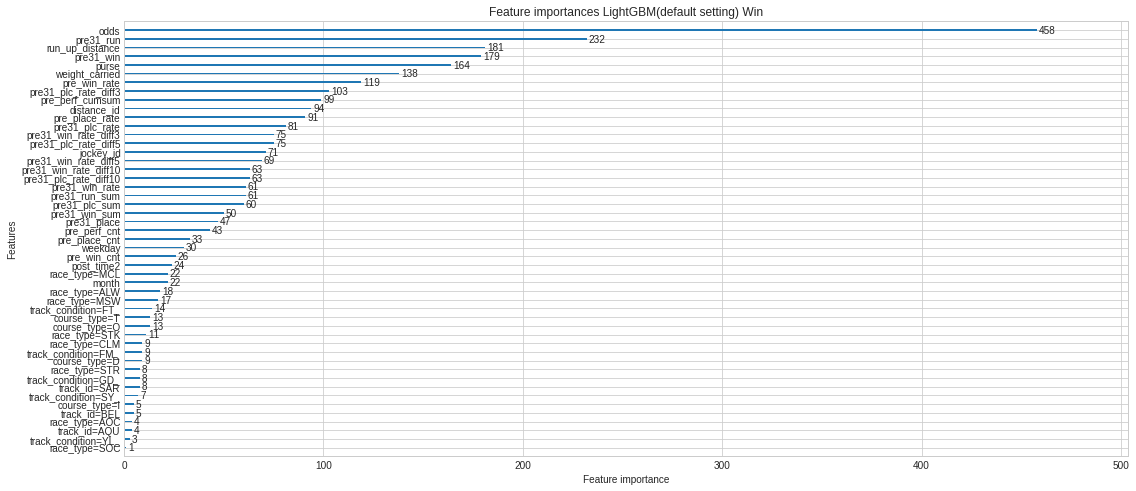

In [69]:
ltb.plot_importance(lgb,figsize=(18,8),title='Feature importances LightGBM(default setting) Win')
plt.savefig('FeatureImportance_LGB_Win.png',dpi=400)

In [70]:
import lightgbm as ltb

lgb = ltb.LGBMClassifier(class_weight='balanced')
lgb.fit(X_train, y_train_plc)
y_pred_plc_lgb = lgb.predict(X_test)

cm_plc_lgb = confusion_matrix(y_test_plc, y_pred_plc_lgb, labels=[1, 0])
auc_plc_lgb = roc_auc_score(y_test_plc, y_pred_plc_lgb)
acc_plc_lgb = accuracy_score(y_test_plc, y_pred_plc_lgb)
f1_plc_lgb= f1_score(y_test_plc, y_pred_plc_lgb, labels=[1, 0])
recall_plc_lgb = recall_score(y_test_plc, y_pred_plc_lgb, labels=[1, 0])
precision_plc_lgb= precision_score(y_test_plc, y_pred_plc_lgb, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of LGB:\n', cm_plc_lgb)
print(f'The auc_score of LGB: {auc_plc_lgb: .05f}')
print(f'The acc_score of LGB: {acc_plc_lgb: .05f}')
print(f'The F-measure of LGB: {f1_plc_lgb: .05f}')
print(f'The recall of LGB: {recall_plc_lgb: .05f}')
print(f'The precision of LGB: {precision_plc_lgb: .05f}')

plc_models['LGB'] = [cm_plc_lgb, auc_plc_lgb, acc_plc_lgb, f1_plc_lgb, recall_plc_lgb, precision_plc_lgb]

For predicting Win:
The confusion matrix of LGB:
 [[ 883  259]
 [ 418 1533]]
The auc_score of LGB:  0.77948
The acc_score of LGB:  0.78112
The F-measure of LGB:  0.72288
The recall of LGB:  0.77320
The precision of LGB:  0.67871


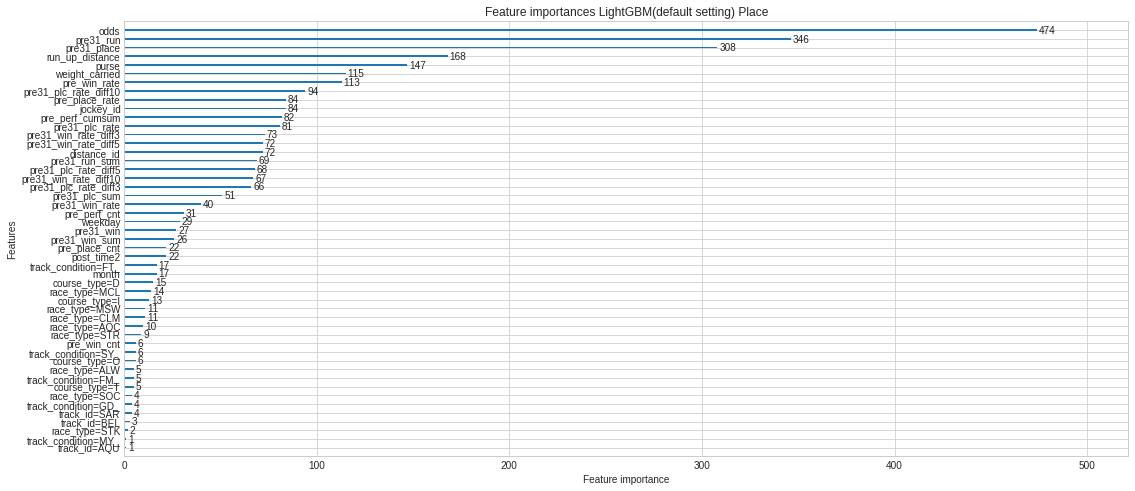

In [71]:
ltb.plot_importance(lgb,figsize=(18,8),title='Feature importances LightGBM(default setting) Place')
plt.savefig('FeatureImportance_LGB_Place.png',dpi=400)

# Check models' performance

#### Models for predicting "Win'

In [72]:
res=pd.DataFrame(win_models.values(), index=win_models.keys(), 
      columns=['confusion_matrix', 'auc_score', 'acc_score', 'f1_score',
          'recall', 'precision']).sort_values(by=['auc_score', 'f1_score'])
res

,confusion_matrix,auc_score,acc_score,f1_score,recall,precision
KNN,"[[24, 356], [31, 2682]]",0.525866,0.874879,0.110345,0.063158,0.436364
RandomForest,"[[84, 296], [29, 2684]]",0.605182,0.894924,0.340771,0.221053,0.743363
NaiveBayes,"[[208, 172], [494, 2219]]",0.682641,0.784675,0.384473,0.547368,0.296296
DecisionTrees,"[[192, 188], [243, 2470]]",0.707847,0.860653,0.471166,0.505263,0.441379
ANN,"[[0, 380], [0, 2713]]",0.771873,0.877142,0.000000,0.000000,0.000000
LGB,"[[282, 98], [357, 2356]]",0.805258,0.852894,0.553484,0.742105,0.441315
SVM,"[[286, 94], [373, 2340]]",0.807573,0.849014,0.550529,0.752632,0.433991
LogisticRegression,"[[290, 90], [380, 2333]]",0.811546,0.848044,0.552381,0.763158,0.432836


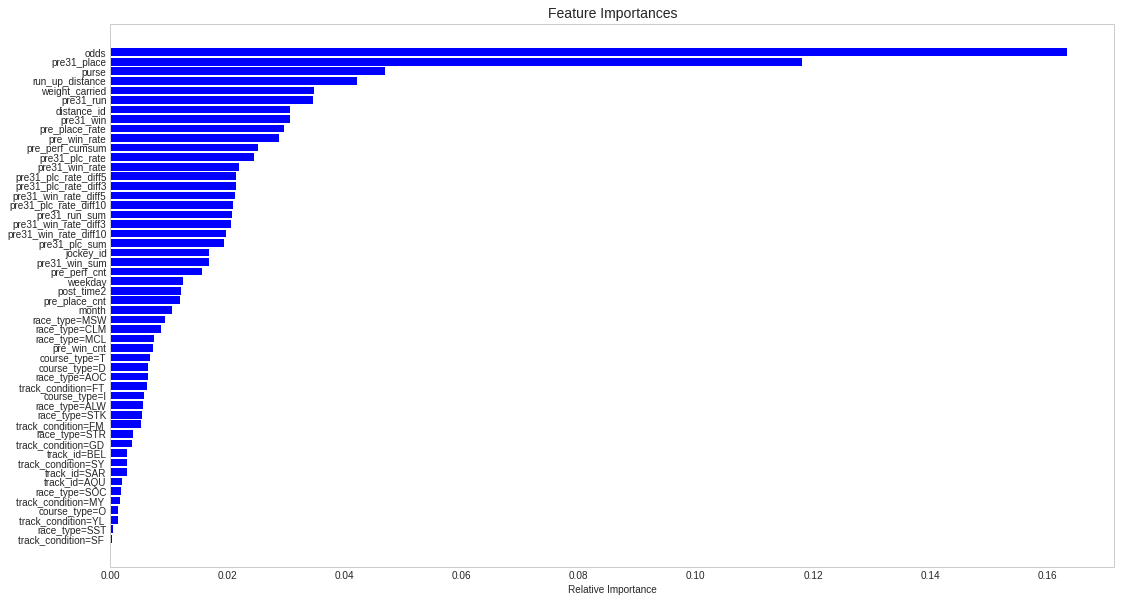

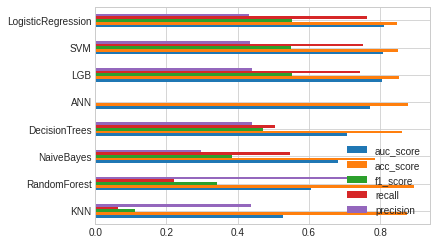

In [73]:
features = X_train.columns
importances = rand_forest.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize = (18, 10))

plt.title('Feature Importances', fontsize=14)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
#plt.ylabel("Count", fontsize=12)
plt.grid()
plt.show()
res.plot(kind='barh')


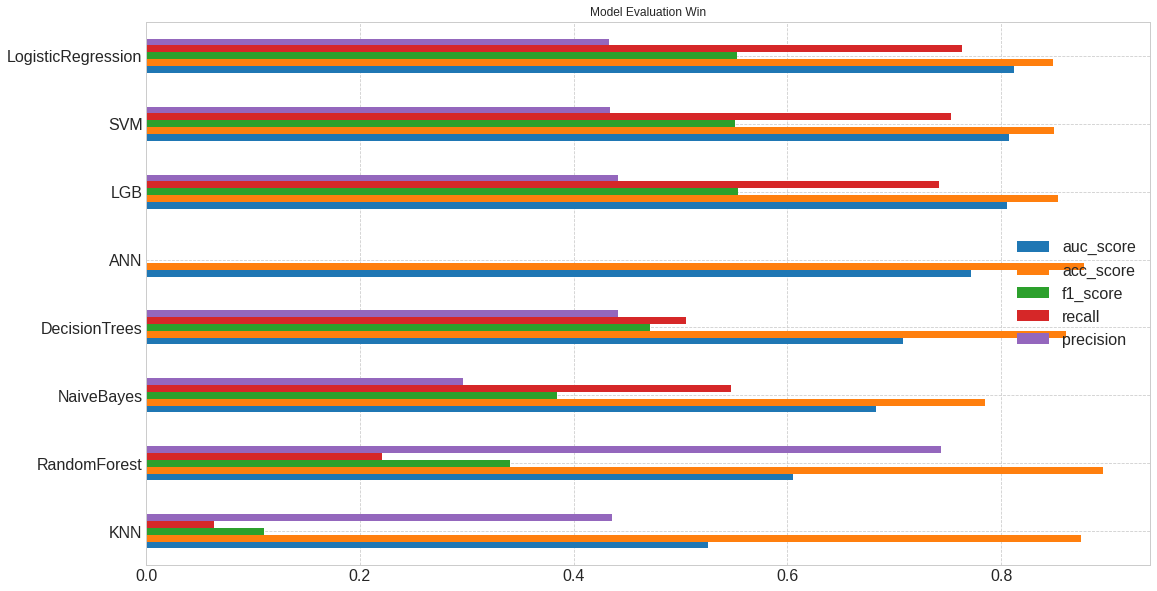

In [74]:
#fig= plt.figure(figsize = (18, 10))
res.plot(kind='barh',figsize=(18,10),title='Model Evaluation Win',fontsize=16)
plt.legend(loc=5, prop={'size': 16})
plt.grid(linestyle = '--')
plt.savefig('Model_evaluation_Win.png',dpi=400)
plt.show()

*Conclution for Win:*

* Through the confusion matrix, can notice that the logistic regression, SVM and ANN predict all as positive, thus they do not make correct prediction on 'Win'.

* The best model for predicting 'Win' seems to be LightGBM. And the Decision Trees model also has not bad performance.

#### **Models for predicting "place"**

In [75]:
pd.DataFrame(plc_models.values(), index=plc_models.keys(), 
      columns=['confusion_matrix', 'auc_score', 'acc_score', 'f1_score',
          'recall', 'precision']).sort_values(by=['auc_score', 'f1_score'])

,confusion_matrix,auc_score,acc_score,f1_score,recall,precision
KNN,"[[518, 624], [483, 1468]]",0.603012,0.642095,0.483434,0.453590,0.517483
NaiveBayes,"[[860, 282], [870, 1081]]",0.653570,0.627546,0.598886,0.753065,0.497110
DecisionTree,"[[701, 441], [436, 1515]]",0.695180,0.716457,0.615182,0.613835,0.616535
RandomForest,"[[727, 415], [317, 1634]]",0.737061,0.763337,0.665142,0.636602,0.696360
LogisticRegression,"[[768, 374], [342, 1609]]",0.748605,0.768510,0.682060,0.672504,0.691892
ANN,"[[715, 427], [550, 1401]]",0.749066,0.684125,0.594101,0.626095,0.565217
SVM,"[[777, 365], [352, 1599]]",0.749982,0.768186,0.684280,0.680385,0.688220
LGB,"[[883, 259], [418, 1533]]",0.779478,0.781119,0.722882,0.773205,0.678709


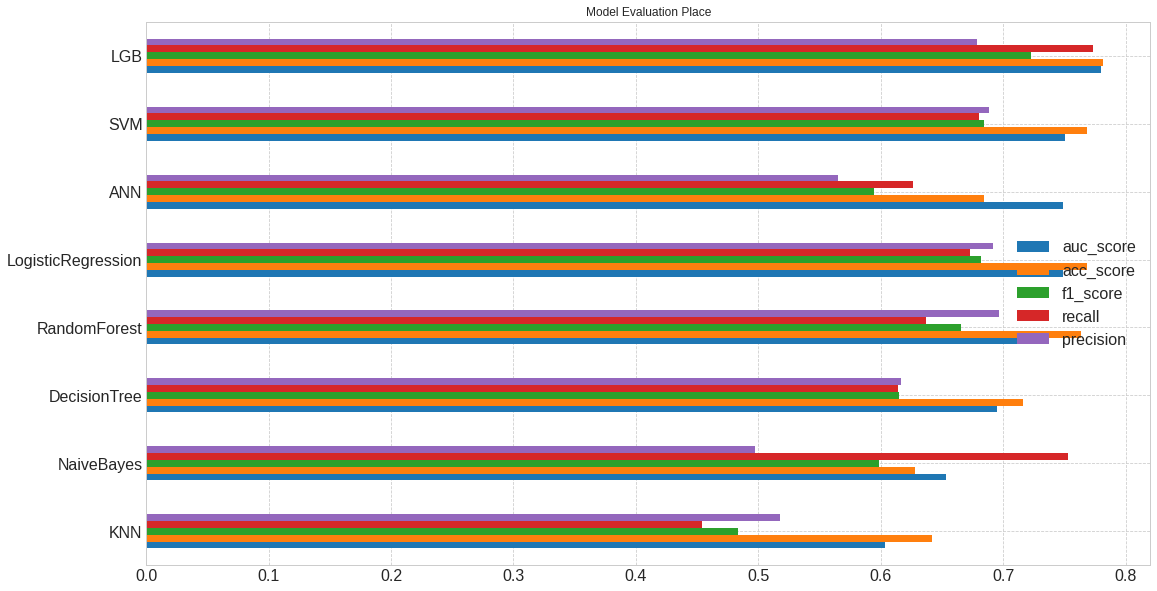

In [76]:
#fig= plt.figure(figsize = (18, 10))
res=pd.DataFrame(plc_models.values(), index=plc_models.keys(), 
      columns=['confusion_matrix', 'auc_score', 'acc_score', 'f1_score',
          'recall', 'precision']).sort_values(by=['auc_score', 'f1_score'])
res.plot(kind='barh',figsize=(18,10),title='Model Evaluation Place',fontsize=16)
plt.legend(loc=5, prop={'size': 16})
plt.grid(linestyle = '--')
plt.savefig('Model_evaluation_Place.png',dpi=400)
plt.show()

*Conclusion for Place:*

* Through the confusion matrix, can notice that the SVM model predicts all as positive, thus it does not make correct prediction on 'Place'.

* The best model seems to be LightGBM, while the Random Forest is also a well performed model.

#### **Conclusion**

* SVM is not a good model in this task based on the chosen features. And the Logistic Regression model and ANN are not suitable for predicting 'Win'.

* The best model for prediction 'Win' and 'Place' seems to be LightGBM.

* Besides, Decision Trees and Random Forest are also good models that can be used in this task.

# Improve Best Model

## hyperopt

In [77]:
from hyperopt import hp

space = {'n_estimators': hp.choice('n_estimators', range(600, 1200, 1)), #num_boost_round
      'boosting_type':hp.choice('boosting_type', ['gbdt']),#boosting
      'objective':hp.choice('objective', ['binary'] ), 'metric':hp.choice('metric', ['auc']),
      'learning_rate': hp.choice('learning_rate', np.arange(0.01, 0.1, 0.01)), 
      'colsample_bytree': hp.choice('colsample_bytree', np.round(np.arange(0.1, 0.86, 0.05),3)), #feature_fraction
      'max_depth': hp.choice('max_depth', range(1, 3, 1)), #int type
      'min_child_samples': hp.choice('min_child_samples',range(10, 501, 5)), #min_data_in_leaf
      'reg_alpha':hp.choice('reg_alpha', [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,15]),#lambda_l1
      'reg_lambda':hp.choice('reg_lambda', [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,15]),#lambda_l2
      'max_bin':hp.choice('max_bin', range(20, 200, 5)), 'min_data_in_bin':hp.choice('min_data_in_bin', range(5, 100, 5)),
      'subsample':hp.choice('subsample', np.round(np.arange(0.1, 0.96, 0.05),3)), #bagging_fraction
      'subsample_freq':hp.choice('subsample_freq', range(1, 20, 1)),#bagging_freq
      #max number of leaves in one tree. 1 < num_leaves <= 131072. classes< num_leaves< 2^max_depth  
      'num_leaves':hp.choice('num_leaves', range(31, 300, 5)),#max_leaves. 
      'random_state':hp.choice('random_state', [1234]), 'n_jobs':hp.choice('n_jobs', [4]),#nthread 
      'scale_pos_weight':hp.choice('scale_pos_weight', [8]),# scale_pos_weight 
      }

## Predicting 'Win'

In [78]:
kfold_win = []
for i in [5, 7, 9]: 
  X_train = df_train.loc[(df_train['race_date']>=train_start) & (df_train['race_date']<f'2019-0{i}-01'), features]
  y_train = df_train.loc[(df_train['race_date']>=train_start) & (df_train['race_date']<f'2019-0{i}-01'), ['target_win']]
  X_test = df_train.loc[(df_train['race_date']>=f'2019-0{i}-01') & (df_train['race_date']<train_end), features]
  y_test = df_train.loc[(df_train['race_date']>=f'2019-0{i}-01') & (df_train['race_date']<train_end), ['target_win']]
  kfold_win.append([X_train, y_train, X_test, y_test])
  print(X_train.shape, X_test.shape)
  display(y_train['target_win'].value_counts() / y_train.shape[0])
  display(y_test['target_win'].value_counts() / y_test.shape[0])

(2740, 52) (7667, 52)


0    0.857664
1    0.142336
Name: target_win, dtype: float64

0    0.866832
1    0.133168
Name: target_win, dtype: float64

(5255, 52) (5152, 52)


0    0.858991
1    0.141009
Name: target_win, dtype: float64

0    0.869953
1    0.130047
Name: target_win, dtype: float64

(8467, 52) (1940, 52)


0    0.864651
1    0.135349
Name: target_win, dtype: float64

0    0.863402
1    0.136598
Name: target_win, dtype: float64

In [79]:
from hyperopt import fmin, STATUS_OK, Trials, tpe, space_eval#, anneal, rand
from functools import partial


def train_trees(X_train, y_train, num_round=100, params={}):   
  params['verbosity'] = -1
  dtrain = ltb.Dataset(X_train, y_train) 
  tree_model = ltb.train(params, dtrain, num_boost_round=num_round)
  del dtrain
  gc.collect()
  return tree_model


loss_dict = []
def score_win(params):
  num_boost_round = params['n_estimators']
  params_ = copy.deepcopy(params)
  del params_['n_estimators']
  losses = [] 
  for X_train,y_train,  X_test,y_test  in kfold_win:
    #-----start: train trees--------
    tree_model = train_trees(X_train, y_train['target_win'].values, 
                  num_round=num_boost_round, params=params_)
    y_preds = tree_model.predict(X_test, num_iteration=tree_model.best_iteration)
    loss = roc_auc_score(y_test['target_win'], y_preds)
    losses.append(loss) 
    #-----end: train trees----------
    loss = np.mean(losses)
    loss_dict.append({'params': params, 'losses': losses, 'mean_loss': loss})
    return {'loss': -loss, 'status': STATUS_OK}


def optimize_win(space, evals, cores, trials, optimizer=tpe.suggest, random_state=1234, n_startup_jobs=10):
  algo = partial(optimizer, n_startup_jobs=n_startup_jobs)
  best = fmin(score_win, space, algo=algo, max_evals=evals, trials = trials)
  bestparams = space_eval(space, best)
  return bestparams

In [80]:
iter_dict_win = {}
for iter_i in range(10):
  print(datetime.now(), iter_i)
  cores = 8
  n_trials = 100
  n_rand_trials = 20
  verbose = False
  trials = Trials()

  best_param_win = optimize_win(space, evals = n_trials, optimizer=tpe.suggest, cores = cores, 
                trials = trials, random_state=1234, n_startup_jobs=n_rand_trials)
    
  iter_dict_win[iter_i] = best_param_win

2022-11-29 08:44:17.690099 0
100%|██████████| 100/100 [00:37<00:00,  2.67it/s, best loss: -0.9094588424900738]
2022-11-29 08:44:55.513879 1
100%|██████████| 100/100 [00:38<00:00,  2.63it/s, best loss: -0.9085846339126314]
2022-11-29 08:45:33.698211 2
100%|██████████| 100/100 [00:39<00:00,  2.53it/s, best loss: -0.9091971841405714]
2022-11-29 08:46:13.280599 3
100%|██████████| 100/100 [00:36<00:00,  2.72it/s, best loss: -0.9083789031010826]
2022-11-29 08:46:50.214095 4
100%|██████████| 100/100 [00:37<00:00,  2.67it/s, best loss: -0.9091010241444855]
2022-11-29 08:47:27.746927 5
100%|██████████| 100/100 [00:37<00:00,  2.68it/s, best loss: -0.9096096036793394]
2022-11-29 08:48:05.173102 6
100%|██████████| 100/100 [00:37<00:00,  2.66it/s, best loss: -0.9093175867716857]
2022-11-29 08:48:42.826697 7
100%|██████████| 100/100 [00:38<00:00,  2.63it/s, best loss: -0.9094748323131777]
2022-11-29 08:49:20.991477 8
100%|██████████| 100/100 [00:38<00:00,  2.58it/s, best loss: -0.908943925974635]
20

In [81]:
lgbm_dict_win = {}
auc_win_lgbm, acc_win_lgbm, cm_win_lgbm, f1_win_lgbm, recall_win_lgbm, precision_win_lgbm = [], [], [], [], [], []


for iter_i, params in iter_dict_win.items():
  params = copy.deepcopy(params)
  num_boost_round = params['n_estimators']
  del params['n_estimators']

  tree_model = train_trees(df_train[features], df_train['target_win'].values, num_round=num_boost_round, params=params)
  y_preds_win_lgbm = tree_model.predict(df_test[features], num_iteration=tree_model.best_iteration)
  lgbm_dict_win[iter_i] = tree_model

  auc_win_lgbm.append(roc_auc_score(df_test['target_win'], y_preds_win_lgbm))
  y_preds_win_lgbm = prob_threshold(y_preds_win_lgbm)
  cm_win_lgbm.append(confusion_matrix(df_test['target_win'], y_preds_win_lgbm, labels=[1, 0]))
  acc_win_lgbm.append(accuracy_score(df_test['target_win'], y_preds_win_lgbm))
  f1_win_lgbm.append(f1_score(df_test['target_win'], y_preds_win_lgbm, labels=[1, 0]))
  recall_win_lgbm.append(recall_score(df_test['target_win'], y_preds_win_lgbm, labels=[1, 0]))
  precision_win_lgbm.append(precision_score(df_test['target_win'], y_preds_win_lgbm, labels=[1, 0]))

best_index_win = auc_win_lgbm.index(max(auc_win_lgbm))
best_auc_win_lgbm, best_acc_win_lgbm = auc_win_lgbm[best_index_win], acc_win_lgbm[best_index_win]
best_cm_win_lgbm, best_f1_win_lgbm = cm_win_lgbm[best_index_win], f1_win_lgbm[best_index_win]
best_recall_win_lgbm, best_precision_win_lgbm = recall_win_lgbm[best_index_win], precision_win_lgbm[best_index_win]

print('For predicting Win:')
print('The confusion matrix of improved LightGBM:\n', best_cm_win_lgbm)
print(f'The auc_score of improved LightGBM: {best_auc_win_lgbm: .05f}')
print(f'The acc_score of improved LightGBM: {best_acc_win_lgbm: .05f}')
print(f'The F-measure of improved LightGBM: {best_f1_win_lgbm: .05f}')
print(f'The recall of improved LightGBM: {best_recall_win_lgbm: .05f}')
print(f'The precision of improved LightGBM: {best_precision_win_lgbm: .05f}')


win_models['LightGBM'] = [best_cm_win_lgbm, best_auc_win_lgbm, best_acc_win_lgbm, 
              best_f1_win_lgbm, best_recall_win_lgbm, best_precision_win_lgbm]

For predicting Win:
The confusion matrix of improved LightGBM:
 [[ 352   28]
 [ 613 2100]]
The auc_score of improved LightGBM:  0.92559
The acc_score of improved LightGBM:  0.79276
The F-measure of improved LightGBM:  0.52342
The recall of improved LightGBM:  0.92632
The precision of improved LightGBM:  0.36477


## Predicting 'Place'

In [82]:
kfold_plc = []
for i in [5, 7, 9]: 
  X_train = df_train.loc[(df_train['race_date']>=train_start) & (df_train['race_date']<f'2019-0{i}-01'), features]
  y_train = df_train.loc[(df_train['race_date']>=train_start) & (df_train['race_date']<f'2019-0{i}-01'), ['target_plc']]
  X_test = df_train.loc[(df_train['race_date']>=f'2019-0{i}-01') & (df_train['race_date']<train_end), features]
  y_test = df_train.loc[(df_train['race_date']>=f'2019-0{i}-01') & (df_train['race_date']<train_end), ['target_plc']]
  kfold_plc.append([X_train, y_train, X_test, y_test])
  print(X_train.shape, X_test.shape)
  display(y_train['target_plc'].value_counts() / y_train.shape[0])
  display(y_test['target_plc'].value_counts() / y_test.shape[0])

(2740, 52) (7667, 52)


0    0.573358
1    0.426642
Name: target_plc, dtype: float64

0    0.601017
1    0.398983
Name: target_plc, dtype: float64

(5255, 52) (5152, 52)


0    0.577545
1    0.422455
Name: target_plc, dtype: float64

0    0.610248
1    0.389752
Name: target_plc, dtype: float64

(8467, 52) (1940, 52)


0    0.594544
1    0.405456
Name: target_plc, dtype: float64

0    0.590206
1    0.409794
Name: target_plc, dtype: float64

In [83]:
loss_dict = []
def score_plc(params):
  num_boost_round = params['n_estimators']
  params_ = copy.deepcopy(params)
  del params_['n_estimators']
  losses = [] 
  for X_train,y_train,  X_test,y_test  in kfold_plc:
    #-----start: train trees--------
    tree_model = train_trees(X_train, y_train['target_plc'].values, num_round=num_boost_round, params=params_)
    y_preds = tree_model.predict(X_test, num_iteration=tree_model.best_iteration)
    loss = roc_auc_score(y_test['target_plc'], y_preds)
    losses.append(loss) 
    #-----end: train trees----------
    loss = np.mean(losses)
    loss_dict.append({'params': params, 'losses': losses, 'mean_loss': loss})
    return {'loss': -loss, 'status': STATUS_OK}
    

def optimize_plc(space, evals, cores, trials, optimizer=tpe.suggest, random_state=1234, n_startup_jobs=10):
  algo = partial(optimizer, n_startup_jobs=n_startup_jobs)
  best = fmin(score_plc, space, algo=algo, max_evals=evals, trials = trials)
  bestparams = space_eval(space, best)
  return bestparams

In [84]:
iter_dict_plc = {}
for iter_i in range(10):
  print(datetime.now(), iter_i)
  cores = 8
  n_trials = 100
  n_rand_trials = 20
  verbose = False
  trials = Trials()

  best_param_plc = optimize_plc(space, evals = n_trials, optimizer=tpe.suggest, cores = cores, 
                trials = trials, random_state=1234, n_startup_jobs=n_rand_trials)
    
  iter_dict_plc[iter_i] = best_param_plc

2022-11-29 08:50:43.145851 0
100%|██████████| 100/100 [00:39<00:00,  2.55it/s, best loss: -0.8477901899222694]
2022-11-29 08:51:22.450161 1
100%|██████████| 100/100 [00:36<00:00,  2.72it/s, best loss: -0.8494831323666957]
2022-11-29 08:51:59.322086 2
100%|██████████| 100/100 [00:38<00:00,  2.60it/s, best loss: -0.8466885553444298]
2022-11-29 08:52:37.850214 3
100%|██████████| 100/100 [00:37<00:00,  2.64it/s, best loss: -0.8490237780252261]
2022-11-29 08:53:15.845570 4
100%|██████████| 100/100 [00:39<00:00,  2.51it/s, best loss: -0.848206517482565]
2022-11-29 08:53:55.746744 5
100%|██████████| 100/100 [00:38<00:00,  2.58it/s, best loss: -0.8480156459990555]
2022-11-29 08:54:34.684060 6
100%|██████████| 100/100 [00:37<00:00,  2.65it/s, best loss: -0.8489926341555881]
2022-11-29 08:55:12.600229 7
100%|██████████| 100/100 [00:39<00:00,  2.52it/s, best loss: -0.8466436840516145]
2022-11-29 08:55:52.343099 8
100%|██████████| 100/100 [00:37<00:00,  2.64it/s, best loss: -0.84966024095565]
2022

In [85]:
lgbm_dict_plc = {}
auc_plc_lgbm, acc_plc_lgbm, cm_plc_lgbm, f1_plc_lgbm, recall_plc_lgbm, precision_plc_lgbm = [], [], [], [], [], []

for iter_i, params in iter_dict_plc.items():
  params = copy.deepcopy(params)
  num_boost_round = params['n_estimators']
  del params['n_estimators']

  tree_model = train_trees(df_train[features], df_train['target_plc'].values, num_round=num_boost_round, params=params)
  y_preds_plc_lgbm = tree_model.predict(df_test[features], num_iteration=tree_model.best_iteration)
  lgbm_dict_plc[iter_i] = tree_model

  auc_plc_lgbm.append(roc_auc_score(df_test['target_plc'], y_preds_plc_lgbm))
  y_preds_plc_lgbm = prob_threshold(y_preds_plc_lgbm)
  cm_plc_lgbm.append(confusion_matrix(df_test['target_plc'], y_preds_plc_lgbm, labels=[1, 0]))
  acc_plc_lgbm.append(accuracy_score(df_test['target_plc'], y_preds_plc_lgbm))
  f1_plc_lgbm.append(f1_score(df_test['target_plc'], y_preds_plc_lgbm, labels=[1, 0]))
  recall_plc_lgbm.append(recall_score(df_test['target_plc'], y_preds_plc_lgbm, labels=[1, 0]))
  precision_plc_lgbm.append(precision_score(df_test['target_plc'], y_preds_plc_lgbm, labels=[1, 0]))

best_index_plc = auc_plc_lgbm.index(max(auc_plc_lgbm))
best_auc_plc_lgbm, best_acc_plc_lgbm = auc_plc_lgbm[best_index_plc], acc_plc_lgbm[best_index_plc]
best_cm_plc_lgbm, best_f1_plc_lgbm = cm_plc_lgbm[best_index_plc], f1_plc_lgbm[best_index_plc]
best_recall_plc_lgbm, best_precision_plc_lgbm = recall_plc_lgbm[best_index_plc], precision_plc_lgbm[best_index_plc]

print('For predicting Place:')
print('The confusion matrix of LightGBM:\n', best_cm_plc_lgbm)
print(f'The auc_score of LightGBM: {best_auc_plc_lgbm: .05f}')
print(f'The acc_score of LightGBM: {best_acc_plc_lgbm: .05f}')
print(f'The F-measure of LightGBM: {best_f1_plc_lgbm: .05f}')
print(f'The recall of LightGBM: {best_recall_plc_lgbm: .05f}')
print(f'The precision of LightGBM: {best_precision_plc_lgbm: .05f}')

plc_models['LightGBM'] = [best_cm_plc_lgbm, best_auc_plc_lgbm, best_acc_plc_lgbm, 
              best_f1_plc_lgbm, best_recall_plc_lgbm, best_precision_plc_lgbm]

For predicting Place:
The confusion matrix of LightGBM:
 [[1127   15]
 [1047  904]]
The auc_score of LightGBM:  0.87064
The acc_score of LightGBM:  0.65664
The F-measure of LightGBM:  0.67973
The recall of LightGBM:  0.98687
The precision of LightGBM:  0.51840


## Feature importance

### For Win Task

The number of left features are: 32


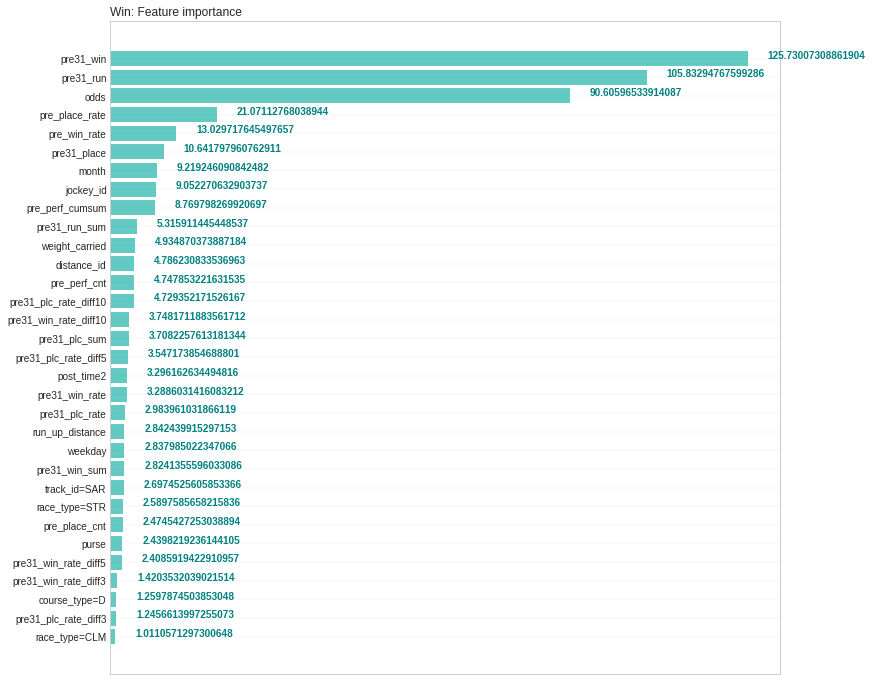

In [86]:
lgbm_scores_win = []
for iter_i, tree_model in lgbm_dict_win.items():
  scores_ = pd.DataFrame(data = {'feat': features, 'gain': tree_model.feature_importance()})
  gain_cut = 0.01*scores_['gain'].sort_values(ascending=False).head(5).mean()
  ss = scores_[scores_['gain']>gain_cut].sort_values(by='gain')
  ss['gain_z'] = (ss['gain']-ss['gain'].min()) / (ss['gain'].quantile(q=0.95)-ss['gain'].quantile(q=0.05))
  ss.reset_index(drop=True, inplace=True)
  ss['rank'] = range(ss.shape[0], 0, -1)
  lgbm_scores_win.append(ss)

lgbm_all_scores_win = pd.concat(lgbm_scores_win, axis=0)

imp_win = pd.pivot_table(lgbm_all_scores_win, index='feat', 
        values=['gain_z'], aggfunc={'gain_z':[np.mean, np.size],})
imp_win.columns = ['score', 'cnt']
imp_win.sort_values(by='score', ascending=True, inplace=True)
imp_win['score'] = 100*imp_win['score']

impt_feats_win = imp_win[imp_win['score']>1]
print('The number of left features are:', impt_feats_win.shape[0])
bar(impt_feats_win['score'], caption='Win: Feature importance', figsize=(12, 12))

### For Place Task

The number of left features are: 37


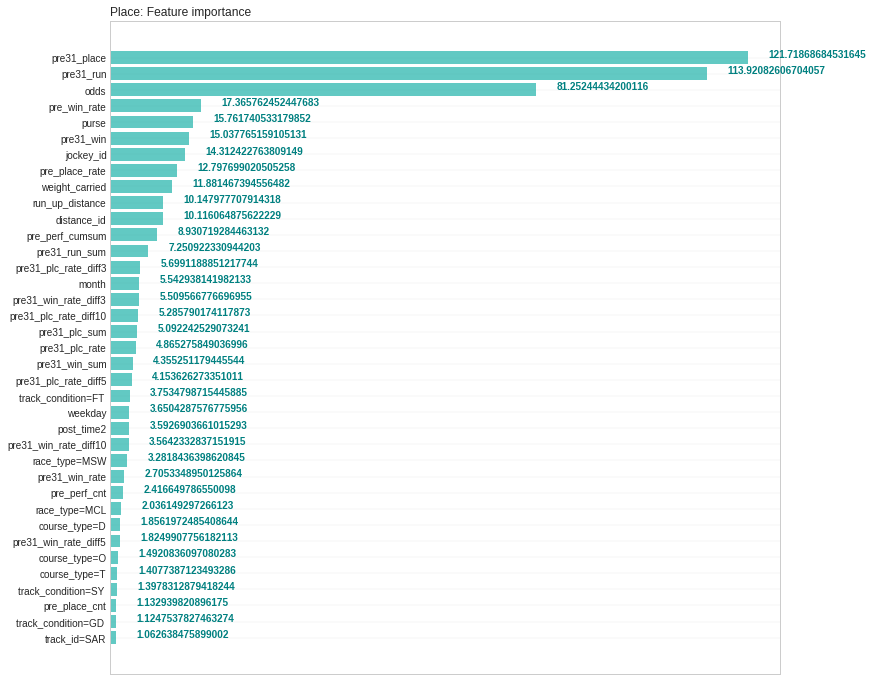

In [87]:
lgbm_scores_plc = []
for iter_i, tree_model in lgbm_dict_plc.items():
  scores_ = pd.DataFrame(data = {'feat': features, 'gain': tree_model.feature_importance()})
  gain_cut = 0.01*scores_['gain'].sort_values(ascending=False).head(5).mean()
  ss = scores_[scores_['gain']>gain_cut].sort_values(by='gain')
  ss['gain_z'] = (ss['gain']-ss['gain'].min()) / (ss['gain'].quantile(q=0.95)-ss['gain'].quantile(q=0.05))
  ss.reset_index(drop=True, inplace=True)
  ss['rank']=range(ss.shape[0], 0, -1)
  lgbm_scores_plc.append(ss)

lgbm_all_scores_plc = pd.concat(lgbm_scores_plc, axis=0)

imp_plc = pd.pivot_table(lgbm_all_scores_plc, index='feat', 
        values=['gain_z'], aggfunc={'gain_z':[np.mean, np.size],})
imp_plc.columns = ['score', 'cnt']
imp_plc.sort_values(by='score', ascending=True, inplace=True)
imp_plc['score'] = 100*imp_plc['score']

impt_feats_plc = imp_plc[imp_plc['score']>1]
print('The number of left features are:', impt_feats_plc.shape[0])
bar(impt_feats_plc['score'], caption='Place: Feature importance', figsize=(12, 12))

## Remove colinear featurs using VIF

In [88]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin

class ReduceVIF(BaseEstimator, TransformerMixin):
  def __init__(self, thresh=5.0):
    self.thresh = thresh

  def fit(self, X):
    return self

  def transform(self, X):
    columns = X.columns.tolist()
    return ReduceVIF.calculate_vif(X, self.thresh)

  @staticmethod
  def calculate_vif(X, thresh=5.0):
    # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
    dropped = True
    while dropped:
      variables = X.columns
      dropped = False
      vif = np.array([variance_inflation_factor(X[variables].values,
              X.columns.get_loc(var)) for var in X.columns])
      max_vif = max(vif)
      if max_vif > thresh:
        maxloc = list(vif).index(vif[vif>thresh][0])
        print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
        X = X.drop([X.columns.tolist()[maxloc]], axis=1)
        dropped=True
    return X

### For Win Task

In [89]:
transformer = ReduceVIF(thresh=20)

print('For Win:')
X_win = transformer.fit_transform(df_train[impt_feats_win.sort_values(by='score',ascending=True).index.values])
final_features_win = X_win.columns.tolist()
print('The number of left features are:', X_win.shape[1])

For Win:
Dropping pre31_win_sum with vif=128.32540812112686
Dropping pre31_plc_rate with vif=85.4910090745757
Dropping pre31_plc_sum with vif=85.42258841419935
Dropping distance_id with vif=83.61465754293246
Dropping weight_carried with vif=52.91131021748269
Dropping month with vif=27.041417521120703
Dropping pre_place_rate with vif=26.659270097595716
The number of left features are: 25


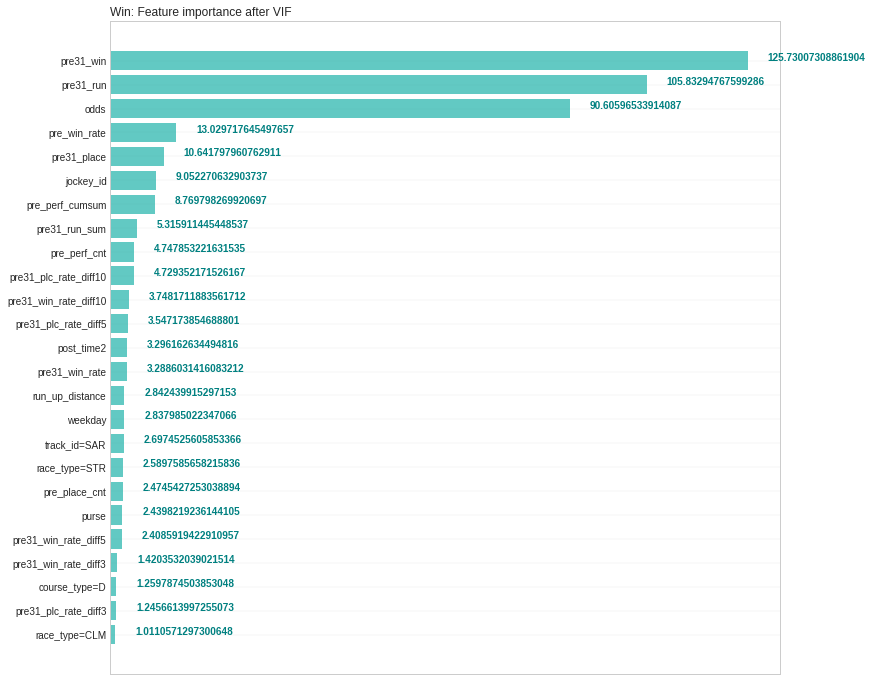

In [90]:
bar(imp_win.loc[final_features_win,'score'], caption='Win: Feature importance after VIF', 
    figsize=(12, 12))

### For Place Task

In [91]:
print('For Place:')
X_plc = transformer.fit_transform(df_train[impt_feats_plc.sort_values(by='score',ascending=True).index.values])
final_features_plc = X_plc.columns.tolist()
print('The number of left features are:', X_plc.shape[1])

For Place:
Dropping pre31_win_rate with vif=128.6665525782184
Dropping pre31_win_sum with vif=110.24970840873884
Dropping pre31_plc_sum with vif=99.70272213078117
Dropping month with vif=98.15170651019987
Dropping distance_id with vif=86.63238415553764
Dropping weight_carried with vif=48.697738050272626
Dropping pre_place_rate with vif=33.949595259045225
The number of left features are: 30


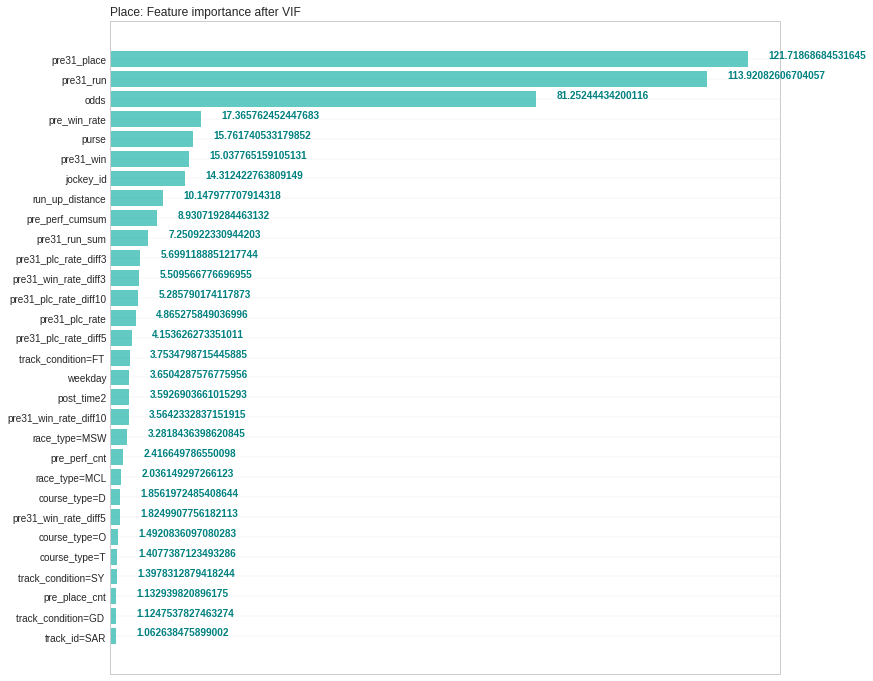

In [92]:
bar(imp_plc.loc[final_features_plc,'score'], caption='Place: Feature importance after VIF', 
    figsize=(12, 12))

## LightGBM Train on Final Features

### For Win Task

In [93]:
lgbm_dict_win_upt = {}
auc_win_lgbm_upt, acc_win_lgbm_upt, cm_win_lgbm_upt = [], [], []
f1_win_lgbm_upt, recall_win_lgbm_upt, precision_win_lgbm_upt = [], [], []
df_pred = pd.DataFrame(data={'target': df_test['target_win'].values})

for iter_i, params in iter_dict_win.items():
  params = copy.deepcopy(params)
  num_boost_round = params['n_estimators']
  del params['n_estimators']

  tree_model = train_trees(df_train[final_features_win], df_train['target_win'].values, 
                  num_round=num_boost_round, params=params)
  y_preds_win_lgbm_upt = tree_model.predict(df_test[final_features_win], 
                  num_iteration=tree_model.best_iteration)
  lgbm_dict_win_upt[iter_i] = tree_model
  df_pred[f'pred{iter_i}'] = y_preds_win_lgbm_upt

  auc_win_lgbm_upt.append(roc_auc_score(df_test['target_win'], y_preds_win_lgbm_upt))
  y_preds_win_lgbm_upt = prob_threshold(y_preds_win_lgbm_upt)
  cm_win_lgbm_upt.append(confusion_matrix(df_test['target_win'], y_preds_win_lgbm, labels=[1, 0]))
  acc_win_lgbm_upt.append(accuracy_score(df_test['target_win'], y_preds_win_lgbm))
  f1_win_lgbm_upt.append(f1_score(df_test['target_win'], y_preds_win_lgbm, labels=[1, 0]))
  recall_win_lgbm_upt.append(recall_score(df_test['target_win'], y_preds_win_lgbm, labels=[1, 0]))
  precision_win_lgbm_upt.append(precision_score(df_test['target_win'], y_preds_win_lgbm, labels=[1, 0]))

best_index_win_upt = auc_win_lgbm_upt.index(max(auc_win_lgbm_upt))
best_auc_win_lgbm_upt, best_acc_win_lgbm_upt = auc_win_lgbm_upt[best_index_win_upt], acc_win_lgbm_upt[best_index_win_upt]
best_cm_win_lgbm_upt, best_f1_win_lgbm_upt = cm_win_lgbm_upt[best_index_win_upt], f1_win_lgbm_upt[best_index_win_upt]
best_recall_win_lgbm_upt = recall_win_lgbm_upt[best_index_win_upt]
best_precision_win_lgbm_upt = precision_win_lgbm_upt[best_index_win_upt]

print('For predicting Win after feature selection:')
print('The confusion matrix of LightGBM:\n', best_cm_win_lgbm_upt)
print(f'The auc_score of LightGBM: {best_auc_win_lgbm_upt: .05f}')
print(f'The acc_score of LightGBM: {best_acc_win_lgbm_upt: .05f}')
print(f'The F-measure of LightGBM: {best_f1_win_lgbm_upt: .05f}')
print(f'The recall of LightGBM: {best_recall_win_lgbm_upt: .05f}')
print(f'The precision of LightGBM: {best_precision_win_lgbm_upt: .05f}')

For predicting Win after feature selection:
The confusion matrix of LightGBM:
 [[ 352   28]
 [ 613 2100]]
The auc_score of LightGBM:  0.92540
The acc_score of LightGBM:  0.79276
The F-measure of LightGBM:  0.52342
The recall of LightGBM:  0.92632
The precision of LightGBM:  0.36477


In [94]:
auc_win_lgbm_upt

[0.9239470774244865,
 0.9240295264515879,
 0.9211161658292432,
 0.9246735988515337,
 0.9230187983781791,
 0.9232472306826781,
 0.9253996352843037,
 0.9253676256620172,
 0.9238403786835316,
 0.9254035152385202]

### For Place Task

In [95]:
lgbm_dict_plc_upt = {}
auc_plc_lgbm_upt, acc_plc_lgbm_upt, cm_plc_lgbm_upt = [], [], []
f1_plc_lgbm_upt, recall_plc_lgbm_upt, precision_plc_lgbm_upt = [], [], []

for iter_i, params in iter_dict_plc.items():
  params = copy.deepcopy(params)
  num_boost_round = params['n_estimators']
  del params['n_estimators']

  tree_model = train_trees(df_train[final_features_plc], df_train['target_plc'].values, 
                  num_round=num_boost_round, params=params)
  y_preds_plc_lgbm_upt = tree_model.predict(df_test[final_features_plc], 
                  num_iteration=tree_model.best_iteration)
  lgbm_dict_plc_upt[iter_i] = tree_model

  auc_plc_lgbm_upt.append(roc_auc_score(df_test['target_plc'], y_preds_plc_lgbm_upt))
  y_preds_plc_lgbm_upt = prob_threshold(y_preds_plc_lgbm_upt)
  cm_plc_lgbm_upt.append(confusion_matrix(df_test['target_plc'], y_preds_plc_lgbm, labels=[1, 0]))
  acc_plc_lgbm_upt.append(accuracy_score(df_test['target_plc'], y_preds_plc_lgbm))
  f1_plc_lgbm_upt.append(f1_score(df_test['target_plc'], y_preds_plc_lgbm, labels=[1, 0]))
  recall_plc_lgbm_upt.append(recall_score(df_test['target_plc'], y_preds_plc_lgbm, labels=[1, 0]))
  precision_plc_lgbm_upt.append(precision_score(df_test['target_plc'], y_preds_plc_lgbm, labels=[1, 0]))

best_index_plc_upt = auc_plc_lgbm_upt.index(max(auc_plc_lgbm_upt))
best_auc_plc_lgbm_upt, best_acc_plc_lgbm_upt = auc_plc_lgbm_upt[best_index_plc_upt], acc_plc_lgbm_upt[best_index_plc_upt]
best_cm_plc_lgbm_upt, best_f1_plc_lgbm_upt = cm_plc_lgbm_upt[best_index_plc_upt], f1_plc_lgbm_upt[best_index_plc_upt]
best_recall_plc_lgbm_upt = recall_plc_lgbm_upt[best_index_plc_upt]
best_precision_plc_lgbm_upt = precision_plc_lgbm_upt[best_index_plc_upt]

print('For predicting Place after feature selection:')
print('The confusion matrix of LightGBM:\n', best_cm_plc_lgbm_upt)
print(f'The auc_score of LightGBM: {best_auc_plc_lgbm_upt: .05f}')
print(f'The acc_score of LightGBM: {best_acc_plc_lgbm_upt: .05f}')
print(f'The F-measure of LightGBM: {best_f1_plc_lgbm_upt: .05f}')
print(f'The recall of LightGBM: {best_recall_plc_lgbm_upt: .05f}')
print(f'The precision of LightGBM: {best_precision_plc_lgbm_upt: .05f}')

For predicting Place after feature selection:
The confusion matrix of LightGBM:
 [[1136    6]
 [1121  830]]
The auc_score of LightGBM:  0.87140
The acc_score of LightGBM:  0.63563
The F-measure of LightGBM:  0.66843
The recall of LightGBM:  0.99475
The precision of LightGBM:  0.50332


In [96]:
auc_plc_lgbm_upt

[0.8714018856017974,
 0.8678700850343035,
 0.8694456836989608,
 0.866503638620816,
 0.8701918545521136,
 0.8693554699597225,
 0.8665563755081817,
 0.8692820871419839,
 0.8686514886164624,
 0.8692324920266314]

## Feature Relationships by SHAP

In [97]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 9.4 MB/s 


## For Win Task

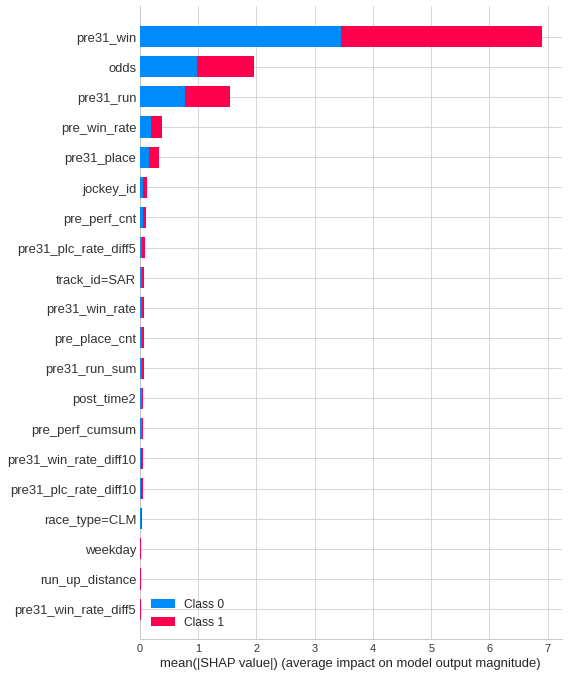

In [98]:
tree_model_win = lgbm_dict_win_upt[best_index_win_upt]#
explainer_win = shap.TreeExplainer(tree_model_win, num_iteration=tree_model_win.best_iteration)
shap_values_win = explainer_win.shap_values(df_test[final_features_win])

shap.summary_plot(shap_values_win, df_test[final_features_win])

## For Place Task

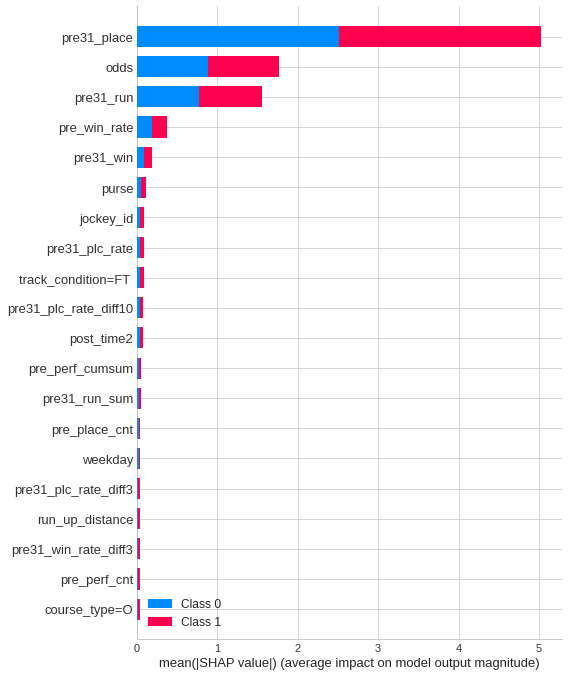

In [99]:
tree_model_plc = lgbm_dict_plc_upt[best_index_plc_upt]#
explainer_plc = shap.TreeExplainer(tree_model_plc, num_iteration=tree_model_plc.best_iteration)
shap_values_plc = explainer_plc.shap_values(df_test[final_features_plc])

shap.summary_plot(shap_values_plc, df_test[final_features_plc])

# Assess

## Prepare datasets

In [100]:
X_train_odds = df_train.odds
y_train_odds = df_train.win

df_test_temp = df_test.copy()
df_test_temp['intercept'] = 1
X_test_odds = df_test_temp[['intercept', 'odds']]
y_test_odds = df_test.win

## Public Odds Model

In [101]:
import statsmodels.api as sm

X_train_odds = sm.add_constant(X_train_odds)
odds_model = sm.Logit(y_train_odds, X_train_odds).fit()
y_predicts_by_odd = odds_model.predict(X_test_odds)
odds_model.summary()

Optimization terminated successfully.
         Current function value: 0.348658
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                10407
Model:                          Logit   Df Residuals:                    10405
Method:                           MLE   Df Model:                            1
Date:                Tue, 29 Nov 2022   Pseudo R-squ.:                  0.1215
Time:                        08:57:51   Log-Likelihood:                -3628.5
converged:                       True   LL-Null:                       -4130.1
Covariance Type:            nonrobust   LLR p-value:                3.426e-220
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7798      0.046    -17.024      0.000      -0.870      -0.690
odds          -0.0014      7e-05    -20.640      0.000      -0.002      -0.001
==============================================================================
"""

## Returns

In [102]:
df_test_earnings = df_test.copy()
df_test_earnings['order'] = range(len(df_test_earnings))

df_test_earnings['win_odds'] = df_test_earnings.odds / 100

predicts = pd.DataFrame(df_pred.pred0)
predicts = predicts.rename(columns={'pred0': 'predicted_win'})
predicts['order'] = range(len(predicts))
df_test_earnings = df_test_earnings.merge(predicts, on=['order'], how='inner')

df_test_earnings['exp_payout'] = df_test_earnings['win_odds'] * df_test_earnings['predicted_win'] * 10


y_predicts_by_odd = pd.DataFrame(y_predicts_by_odd)
y_predicts_by_odd = y_predicts_by_odd.rename(columns={0: 'predicted_odds'})
y_predicts_by_odd['order'] = range(len(y_predicts_by_odd))
df_test_earnings = df_test_earnings.merge(y_predicts_by_odd, on=['order'], how='inner')
df_test_earnings['exp_payout_odd'] = df_test_earnings['win_odds'] * df_test_earnings['predicted_odds'] * 10
df_test_earnings


,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,id,target_win,target_plc,weekday,month,post_time2,track_id=AQU,track_id=BEL,track_id=SAR,course_type=D,course_type=I,course_type=O,course_type=T,track_condition=FM,track_condition=FT,track_condition=GD,track_condition=MY,track_condition=SF,track_condition=SY,track_condition=YL,race_type=ALW,race_type=AOC,race_type=CLM,race_type=MCL,race_type=MSW,race_type=SOC,race_type=SST,race_type=STK,race_type=STR,jockey_id,perf_cnt,win_cnt,place_cnt,perf_cumsum,win_rate,place_rate,pre_race_date,pre_perf_cnt,pre_win_cnt,pre_place_cnt,pre_perf_cumsum,pre_win_rate,pre_place_rate,win,place,pre31_place,pre31_run,pre31_win,pre31_plc_sum,pre31_win_sum,pre31_run_sum,pre31_plc_rate,pre31_win_rate,pre31_plc_rate_diff3,pre31_plc_rate_diff5,pre31_plc_rate_diff10,pre31_win_rate_diff3,pre31_win_rate_diff5,pre31_win_rate_diff10,order,win_odds,predicted_win,exp_payout,predicted_odds,exp_payout_odd
0,AQU,2019-11-01,1,1,120,Samuel Camacho Jr.,7475,6,650,D,MY,36,CLM,28000,1200,3481,0,0,4,11,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,38,4,0.0,0.0,155,0.070968,0.264516,2019-10-26 00:00:00,1.0,0.0,0.0,151.0,0.072848,0.271523,0,0,0.0,4.0,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,74.75,0.001327,0.992006,0.000009,0.006979
1,AQU,2019-11-01,1,2,120,Angel Castillo,1960,5,650,D,MY,36,CLM,28000,1200,3482,0,0,4,11,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,80,2,0.0,0.0,3,0.333333,0.333333,2019-10-25 00:00:00,1.0,1.0,1.0,1.0,1.000000,1.000000,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,19.60,0.143286,28.083961,0.026285,5.151816
2,AQU,2019-11-01,1,3,120,Kendrick Carmouche,460,7,650,D,MY,36,CLM,28000,1200,3483,0,0,4,11,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,56,5,0.0,2.0,547,0.135283,0.378428,2019-10-26 00:00:00,3.0,0.0,2.0,542.0,0.136531,0.378229,0,0,2.0,5.0,0.0,46.0,12.0,122.0,0.377049,0.098361,0.014146,0.018075,0.025698,0.001586,0.004344,0.017280,2,4.60,0.009190,0.422738,0.190840,8.778624
3,AQU,2019-11-01,1,4,120,Jorge A. Vargas Jr.,1080,2,650,D,MY,36,CLM,28000,1200,3484,0,1,4,11,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,14,2,0.0,1.0,22,0.136364,0.363636,2019-09-22 00:00:00,1.0,0.0,1.0,20.0,0.150000,0.350000,0,1,1.0,2.0,0.0,1.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,3,10.80,0.015650,1.690162,0.087825,9.485057
4,AQU,2019-11-01,1,5,120,Jose Lezcano,60,1,650,D,MY,36,CLM,28000,1200,3485,1,1,4,11,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,3,6,2.0,6.0,773,0.208279,0.476067,2019-10-26 00:00:00,5.0,0.0,3.0,767.0,0.207301,0.471969,1,1,6.0,6.0,2.0,70.0,28.0,153.0,0.457516,0.183007,0.002388,0.006297,0.036785,-0.009301,-0.006018,0.006177,4,0.60,0.916318,5.497910,0.295974,1.775841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,BEL,2019-10-26,10,5,118,Eric Cancel,1710,2,600,I,GD,138,ALW,66000,551,11718,0,1,5,10,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,9,3,1.0,2.0,543,0.114180,0.423573,2019-10-25 00:00:00,3.0,1.0,1.0,540.0,0.112963,0.422222,0,1,2.0,3.0,1.0,30.0,5.0,79.0,0.379747,0.063291,-0.010497,0.010699,0.034068,0.014511,0.015672,0.026254,3088,17.10,0.641981,109.778671,0.037296,6.377566
3089,BEL,2019-10-26,10,6,121,Joe Bravo,325,3,600,I,GD,138,ALW,66000,551,11719,0,1,5,10,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,73,5,0.0,2.0,131,0.076336,0.312977,2019-10-24 00:00:00,3.0,1.0,1.0,126.0,0.079365,0.309524,0,1,2.0,5.0,0.0,12.0,5.0,42.0,0.285714,0.119048,0.010714,0.017422,0.019048,0.019048,0.021487,0.019048,3089,3.25,0.012415,0.403480,0.222790,7.240666


## race_id

In [103]:
df_test_earnings['race_id']=df_test_earnings.groupby(['race_date', 'race_number']).ngroup().add(1)

In [104]:
orders = df_test_earnings.columns[:-1]
orders = orders.insert(0, 'race_id')
df_test_earnings = df_test_earnings[orders]
df_test_earnings.columns

Index(['race_id', 'track_id', 'race_date', 'race_number', 'program_number',
       'weight_carried', 'jockey', 'odds', 'position_at_finish', 'distance_id',
       'course_type', 'track_condition', 'run_up_distance', 'race_type',
       'purse', 'post_time', 'id', 'target_win', 'target_plc', 'weekday',
       'month', 'post_time2', 'track_id=AQU', 'track_id=BEL', 'track_id=SAR',
       'course_type=D', 'course_type=I', 'course_type=O', 'course_type=T',
       'track_condition=FM ', 'track_condition=FT ', 'track_condition=GD ',
       'track_condition=MY ', 'track_condition=SF ', 'track_condition=SY ',
       'track_condition=YL ', 'race_type=ALW', 'race_type=AOC',
       'race_type=CLM', 'race_type=MCL', 'race_type=MSW', 'race_type=SOC',
       'race_type=SST', 'race_type=STK', 'race_type=STR', 'jockey_id',
       'perf_cnt', 'win_cnt', 'place_cnt', 'perf_cumsum', 'win_rate',
       'place_rate', 'pre_race_date', 'pre_perf_cnt', 'pre_win_cnt',
       'pre_place_cnt', 'pre_perf_cumsum', 

In [105]:
df_test_earnings['race_id'].max()

380

## Returns(odds)

In [106]:
from tqdm import tqdm
import random

odds_earn = []
simuls = 1000
race_count = df_test_earnings['race_id'].max()

for j in tqdm(range(simuls)):
    i = 0
    suma = 0
    while i < race_count:
        temp = df_test_earnings[df_test_earnings['race_id']==i]

        if temp['exp_payout_odd'].max() < 10 or len(temp) <= 0:
            i += 1
        else:
            random_num = random.randint(0, len(temp)-1)

            while temp.iloc[random_num]['exp_payout_odd'] < 10:
                random_num = random.randint(0, len(temp)-1)
            
            if (temp.iloc[random_num]['win'] == 1):
                suma += (temp.iloc[random_num]['odds']/100)*10
            else:
                suma -= 10
            i += 1
    odds_earn.append(suma)


100%|██████████| 1000/1000 [08:38<00:00,  1.93it/s]


## Returns (model and random)

In [107]:
from tqdm import tqdm
import random

predict_earn = []
random_earn = []

simuls = 1000
race_count = df_test_earnings['race_id'].max()
random_earn = []

for j in tqdm(range(simuls)):
    i = 0
    earnings = 0
    avg_earnings = 0

    while i < race_count:
        temp = df_test_earnings[df_test_earnings['race_id']==i]
        if len(temp) > 0:
            rand = random.randint(0, len(temp) - 1)

            if (temp.iloc[rand]['win'] == 1):
                avg_earnings += (temp.iloc[rand]['odds']/100)*10
            else:
                avg_earnings += -10

        if temp['exp_payout'].max() < 10 or len(temp) <= 0:
            i += 1
        else:
            random_num = random.randint(0, len(temp)-1)

            while temp.iloc[random_num]['exp_payout'] < 10:
                random_num = random.randint(0, len(temp)-1)
            
            if (temp.iloc[random_num]['win'] == 1):
                earnings += (temp.iloc[random_num]['odds']/100)*10
            else:
                earnings -= 10
            i += 1
    predict_earn.append(earnings)
    random_earn.append(avg_earnings)



100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


Plot

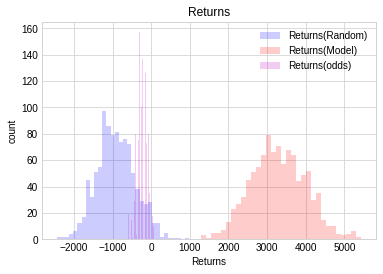

In [108]:
import numpy as np
import random
from matplotlib import pyplot as plt

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"})
bin = 32
plt.hist(random_earn, bins=bin, alpha = .2, color = 'b', label = "Returns(Random)")
plt.hist(predict_earn, bins=bin, alpha = .2, color = 'r', label = "Returns(Model)")
plt.hist(odds_earn, bins=bin, alpha = .2, color = 'm', label = "Returns(odds)")
# plt.hist(expect_predict_earn, bins=bin, alpha = .2, color = 'g', label = "expect-win-odds earnings")

plt.title('Returns')
plt.xlabel('Returns')
plt.ylabel('count')
plt.legend()
plt.savefig('returns.png')
plt.show()